In [122]:
# refer from Mish https://github.com/digantamisra98/Mish/blob/master/Layers_Acc.ipynb
# SwishT (ours) vs Mish, Swish, GELU, etc 

import sys
sys.path.append('../')
import easydict # pip install easydict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# external location
from experiments.activation.acts import *
from experiments.data.datasets import MNIST,CIFAR10,CIFAR100


In [40]:
# Configs
conf = easydict.EasyDict()
conf.batchsize = 128
conf.num_classes = 10
conf.epochs = 10


In [120]:
class CustomCNN(nn.Module):
    def __init__(self, num_layers, num_classes=10,activation=None,hidden_uints=500):
        super(CustomCNN, self).__init__()
        # Define the initial convolution layers
        self.conv1 = nn.Conv2d(3, 20, kernel_size=5, padding=2)  # Assuming input is 1 channel (MNIST)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.act = activation
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fcs_init = nn.Linear(50 * 16 * 16, hidden_uints) 
        self.fcs = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_uints, hidden_uints),  
            nn.BatchNorm1d(hidden_uints),
            self.act,
            nn.Dropout(0.25)
        ) for i in range(num_layers-1)])
        # Final layer
        self.final_fc = nn.Linear(hidden_uints, num_classes)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fcs_init(x)
        for fc in self.fcs:
            x = fc(x)
        x = self.final_fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch,verbose=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_acc:.0f}%)\n')

    return test_acc


def model_relu(num_layers,activation,epochs,lr=0.1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    print(device)
    trainloader = DataLoader(MNIST(train=True),batch_size=conf.batchsize,num_workers=2)
    testloader = DataLoader(MNIST(train=False),batch_size=1024,num_workers=2)
    model = CustomCNN(num_layers=num_layers,num_classes=100,activation=activation)
    model.to(device)
    optimizer=torch.optim.SGD(model.parameters(),lr=lr)

    best_acc = -1
    for epoch in range(epochs):
        print(epoch,' training..')
        train(model,device=device,train_loader=trainloader,optimizer=optimizer,epoch=epoch)
        test_acc = test(model,device,test_loader=testloader)
        if test_acc > best_acc:
            best_acc = test_acc
    
    return best_acc

def plot_result(results,desc='Testing Accuracy vs Number of Layers on CIFAR10'):
    labels = list(range(16,107,10)) #(15, 17, 19, 21, 23, 25)
    positions = list(range(len(labels))) 
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    for name, data in results.items():
        plt.plot(data,'-o', label= name)
    plt.legend(loc='best', fontsize=15)
    plt.xticks(positions, labels)
    plt.grid()
    plt.xlabel('Number of Layers', fontsize = 20)
    plt.ylabel('Testing Accuracy', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.title.set_text(desc)
    ax.title.set_fontsize(20)
    plt.savefig("layersacc.png", bbox_inches = 'tight')
    plt.show()

In [108]:
list(range(16,107,10))

[16, 26, 36, 46, 56, 66, 76, 86, 96, 106]

Swish 16  layers
cuda:0
0  training..



Test set: Average loss: 0.0951, Accuracy: 9729/10000 (97%)

1  training..

Test set: Average loss: 0.0495, Accuracy: 9853/10000 (99%)

2  training..

Test set: Average loss: 0.0512, Accuracy: 9863/10000 (99%)

3  training..

Test set: Average loss: 0.0349, Accuracy: 9890/10000 (99%)

4  training..

Test set: Average loss: 0.0407, Accuracy: 9879/10000 (99%)

5  training..

Test set: Average loss: 0.0331, Accuracy: 9907/10000 (99%)

6  training..

Test set: Average loss: 0.0311, Accuracy: 9909/10000 (99%)

7  training..

Test set: Average loss: 0.0319, Accuracy: 9905/10000 (99%)

8  training..

Test set: Average loss: 0.0318, Accuracy: 9913/10000 (99%)

9  training..

Test set: Average loss: 0.0339, Accuracy: 9909/10000 (99%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13]}


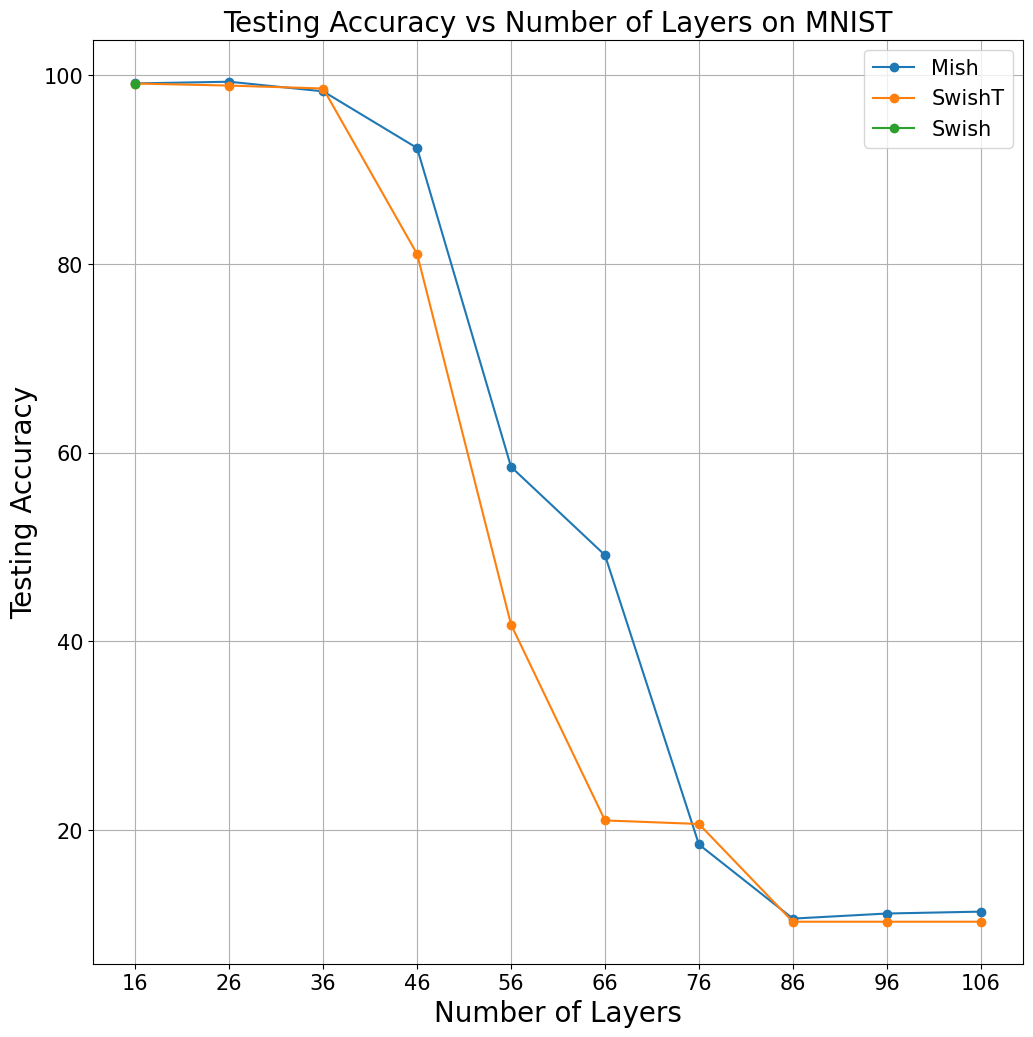

26  layers
cuda:0
0  training..

Test set: Average loss: 0.8905, Accuracy: 6394/10000 (64%)

1  training..

Test set: Average loss: 0.5544, Accuracy: 6864/10000 (69%)

2  training..

Test set: Average loss: 0.1586, Accuracy: 9699/10000 (97%)

3  training..

Test set: Average loss: 0.1707, Accuracy: 9682/10000 (97%)

4  training..

Test set: Average loss: 0.0817, Accuracy: 9846/10000 (98%)

5  training..

Test set: Average loss: 0.0831, Accuracy: 9847/10000 (98%)

6  training..

Test set: Average loss: 0.0729, Accuracy: 9858/10000 (99%)

7  training..

Test set: Average loss: 0.0523, Accuracy: 9902/10000 (99%)

8  training..

Test set: Average loss: 0.0514, Accuracy: 9898/10000 (99%)

9  training..

Test set: Average loss: 0.0572, Accuracy: 9887/10000 (99%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02]}


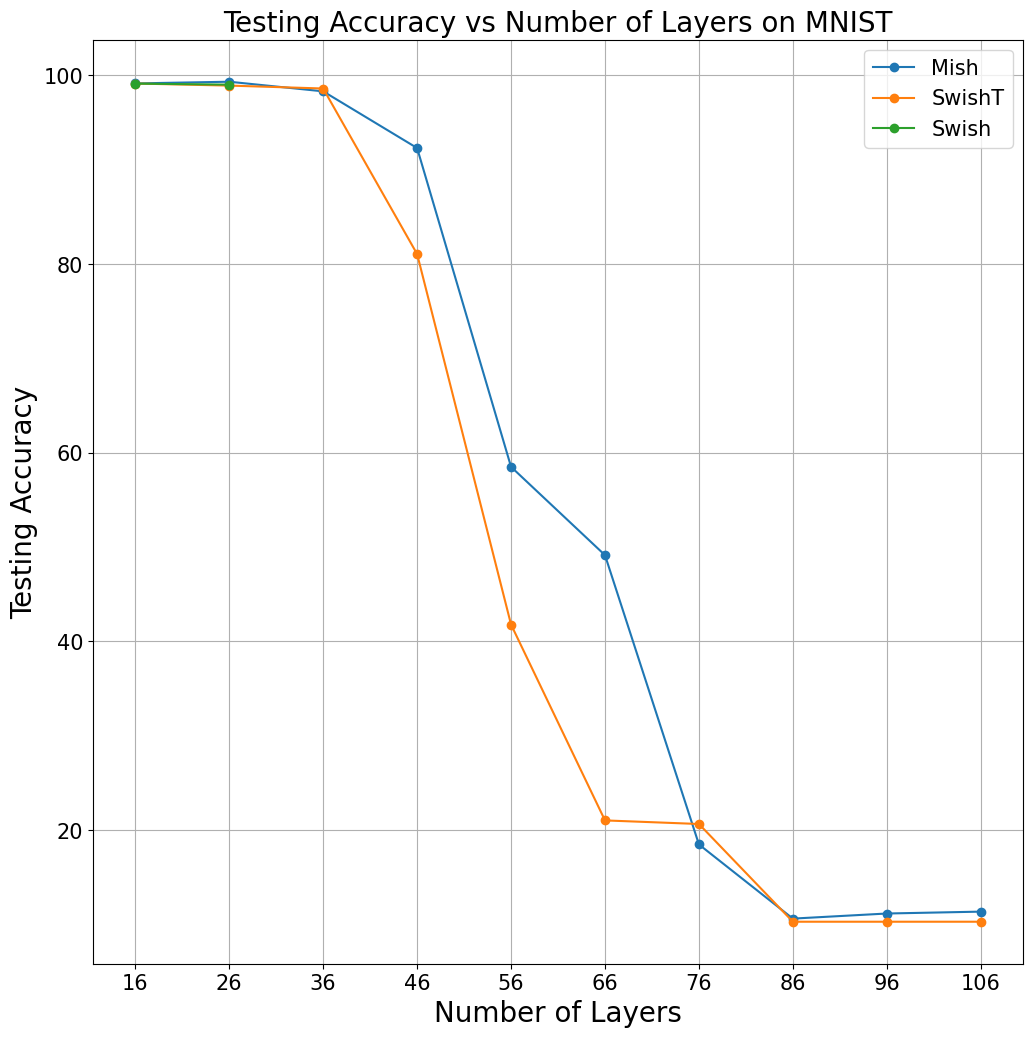

36  layers
cuda:0
0  training..

Test set: Average loss: 2.1369, Accuracy: 1528/10000 (15%)

1  training..

Test set: Average loss: 1.2090, Accuracy: 4620/10000 (46%)

2  training..

Test set: Average loss: 1.4452, Accuracy: 4648/10000 (46%)

3  training..

Test set: Average loss: 1.1329, Accuracy: 5569/10000 (56%)

4  training..

Test set: Average loss: 0.9195, Accuracy: 6962/10000 (70%)

5  training..

Test set: Average loss: 0.6302, Accuracy: 7846/10000 (78%)

6  training..

Test set: Average loss: 0.4063, Accuracy: 8497/10000 (85%)

7  training..

Test set: Average loss: 0.3875, Accuracy: 8572/10000 (86%)

8  training..

Test set: Average loss: 0.3391, Accuracy: 8687/10000 (87%)

9  training..

Test set: Average loss: 0.3093, Accuracy: 8735/10000 (87%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35]}


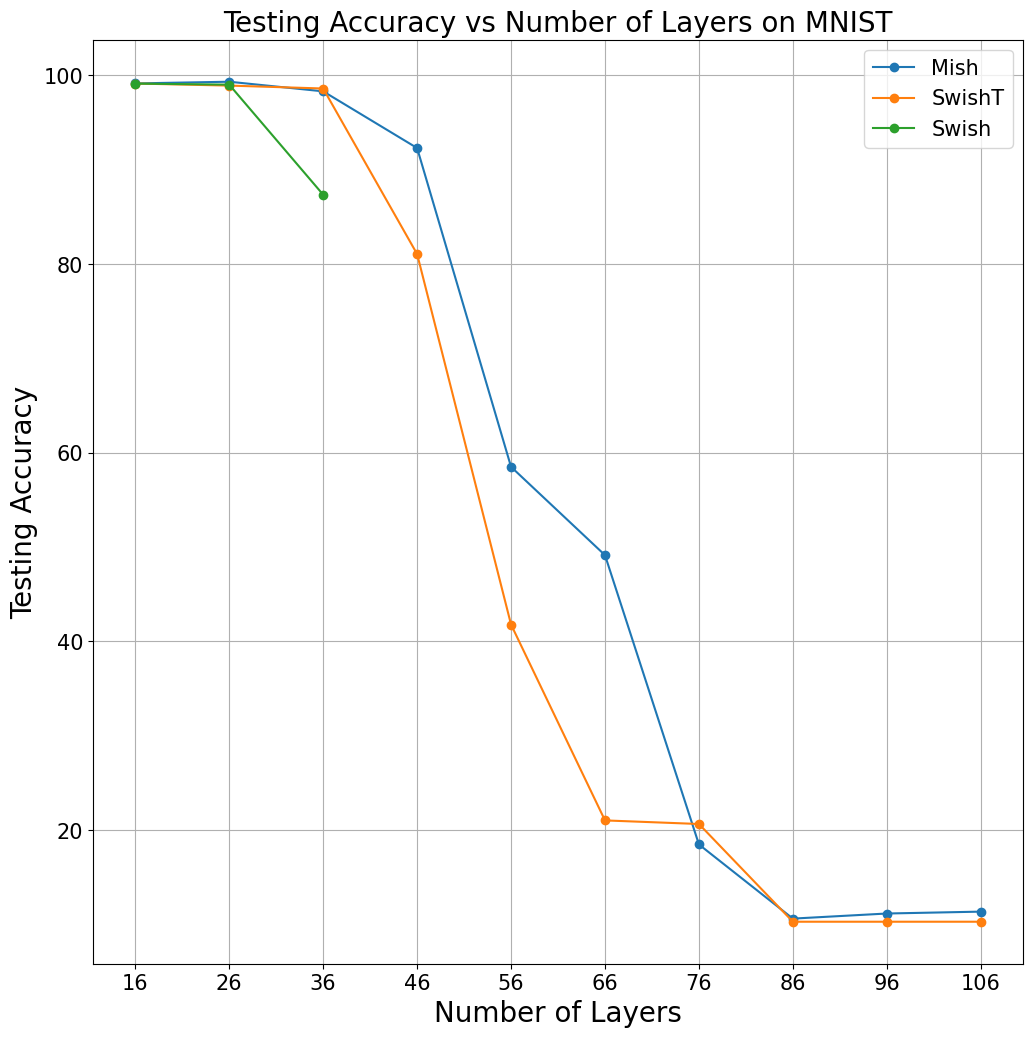

46  layers
cuda:0
0  training..

Test set: Average loss: 2.3074, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3046, Accuracy: 1118/10000 (11%)

2  training..

Test set: Average loss: 2.1127, Accuracy: 1928/10000 (19%)

3  training..

Test set: Average loss: 2.0745, Accuracy: 2093/10000 (21%)

4  training..

Test set: Average loss: 1.5403, Accuracy: 3510/10000 (35%)

5  training..

Test set: Average loss: 1.0977, Accuracy: 5421/10000 (54%)

6  training..

Test set: Average loss: 0.9829, Accuracy: 5884/10000 (59%)

7  training..

Test set: Average loss: 1.0065, Accuracy: 5434/10000 (54%)

8  training..

Test set: Average loss: 1.1276, Accuracy: 5517/10000 (55%)

9  training..

Test set: Average loss: 1.4977, Accuracy: 4457/10000 (45%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84]}


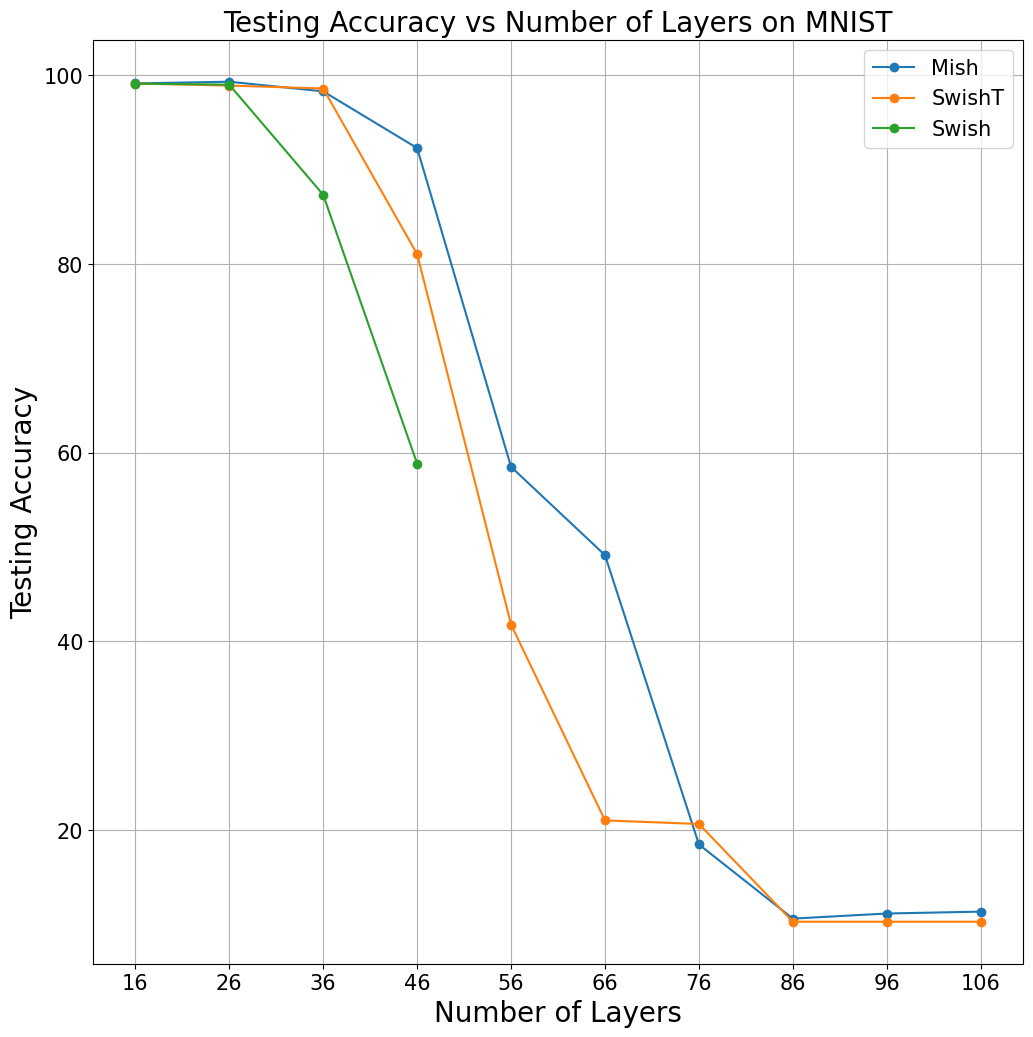

56  layers
cuda:0
0  training..

Test set: Average loss: 2.3032, Accuracy: 1061/10000 (11%)

1  training..

Test set: Average loss: 2.3151, Accuracy: 1010/10000 (10%)

2  training..

Test set: Average loss: 2.3181, Accuracy: 1027/10000 (10%)

3  training..

Test set: Average loss: 2.2818, Accuracy: 1228/10000 (12%)

4  training..

Test set: Average loss: 2.2175, Accuracy: 1484/10000 (15%)

5  training..

Test set: Average loss: 2.1666, Accuracy: 1648/10000 (16%)

6  training..

Test set: Average loss: 2.1216, Accuracy: 1921/10000 (19%)

7  training..

Test set: Average loss: 2.1197, Accuracy: 1991/10000 (20%)

8  training..

Test set: Average loss: 2.0778, Accuracy: 1951/10000 (20%)

9  training..

Test set: Average loss: 2.0123, Accuracy: 2053/10000 (21%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53]}


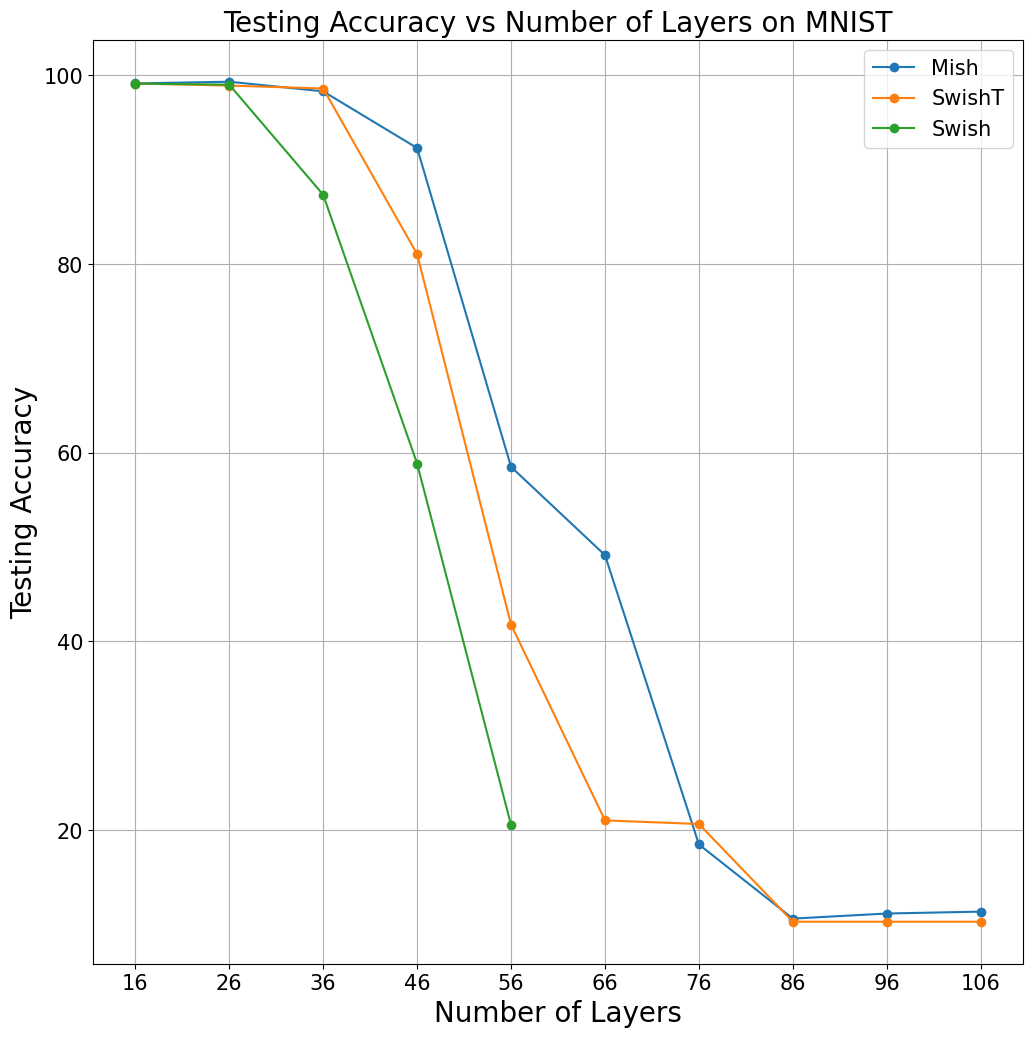

66  layers
cuda:0
0  training..

Test set: Average loss: 2.3056, Accuracy: 1135/10000 (11%)

1  training..

Test set: Average loss: 2.3078, Accuracy: 1135/10000 (11%)

2  training..

Test set: Average loss: 2.3205, Accuracy: 1135/10000 (11%)

3  training..

Test set: Average loss: 2.3237, Accuracy: 1135/10000 (11%)

4  training..

Test set: Average loss: 2.3282, Accuracy: 1030/10000 (10%)

5  training..

Test set: Average loss: 2.3234, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3229, Accuracy: 1035/10000 (10%)

7  training..

Test set: Average loss: 2.3183, Accuracy: 1214/10000 (12%)

8  training..

Test set: Average loss: 2.3156, Accuracy: 1256/10000 (13%)

9  training..

Test set: Average loss: 2.2847, Accuracy: 1241/10000 (12%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56]}


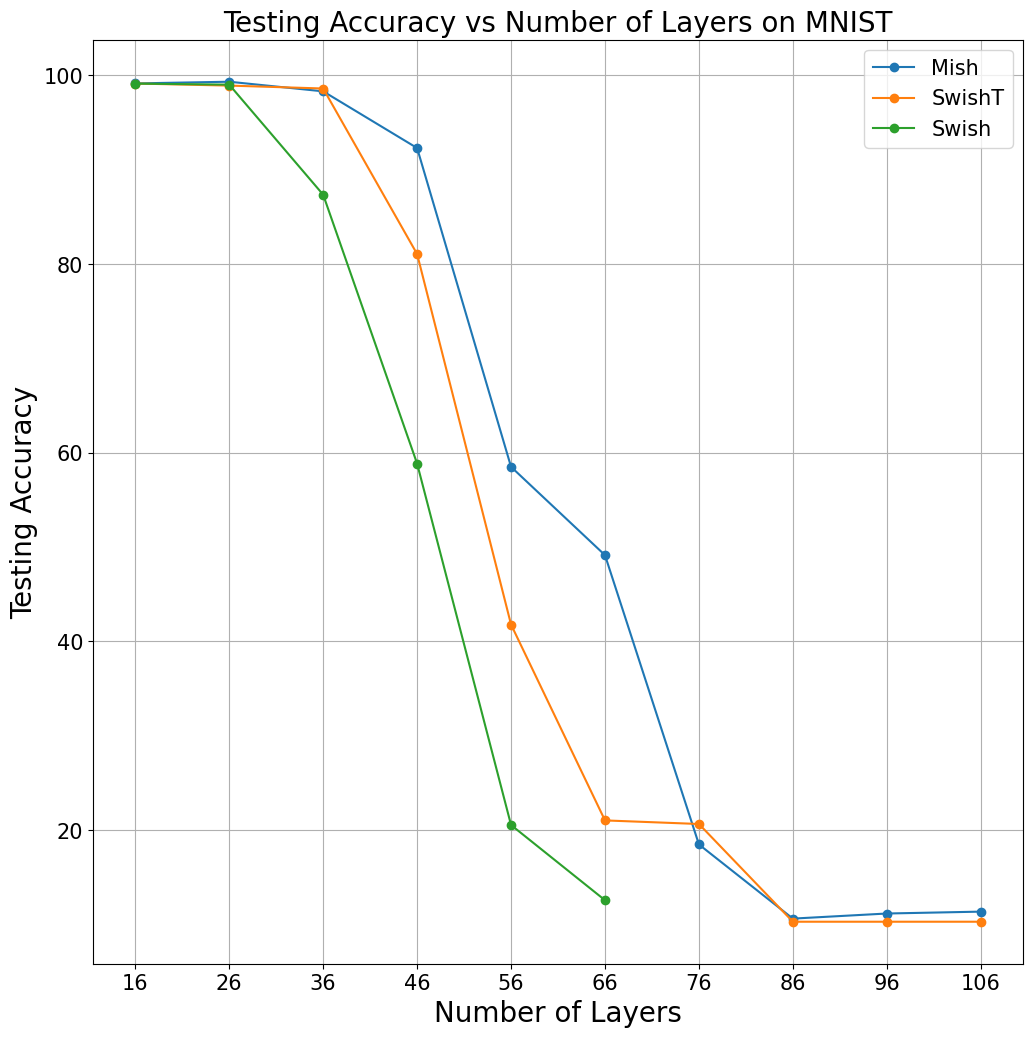

76  layers
cuda:0
0  training..

Test set: Average loss: 2.3021, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3019, Accuracy: 1135/10000 (11%)

2  training..

Test set: Average loss: 2.3022, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3024, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3015, Accuracy: 1135/10000 (11%)

5  training..

Test set: Average loss: 2.3019, Accuracy: 1135/10000 (11%)

6  training..

Test set: Average loss: 2.3024, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3023, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3017, Accuracy: 1135/10000 (11%)

9  training..

Test set: Average loss: 2.3023, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35]}


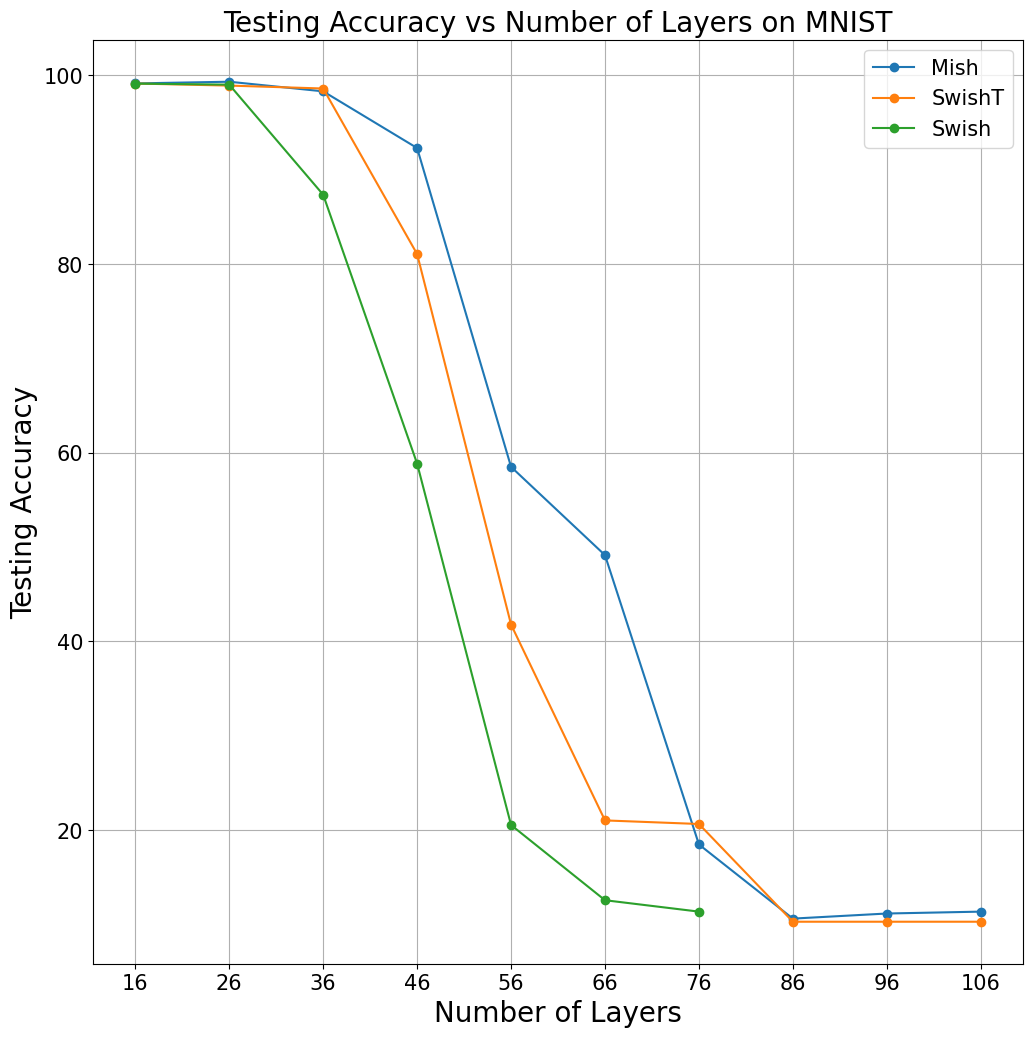

86  layers
cuda:0
0  training..

Test set: Average loss: 2.3031, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3037, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3021, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3026, Accuracy: 1135/10000 (11%)

4  training..

Test set: Average loss: 2.3030, Accuracy: 1028/10000 (10%)

5  training..

Test set: Average loss: 2.3037, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3023, Accuracy: 1135/10000 (11%)

7  training..

Test set: Average loss: 2.3025, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3021, Accuracy: 1028/10000 (10%)

9  training..

Test set: Average loss: 2.3028, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35]}


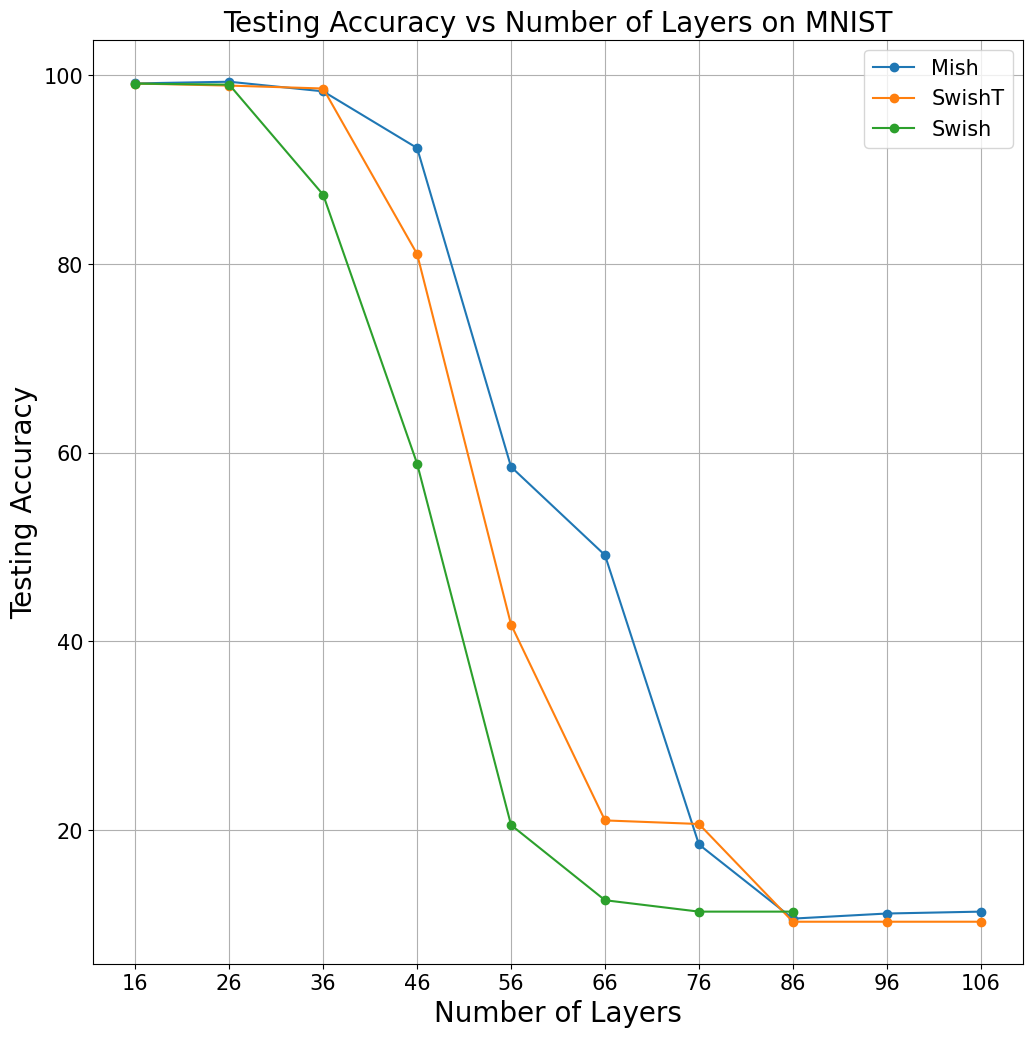

96  layers
cuda:0
0  training..

Test set: Average loss: 2.3025, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3019, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3019, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)

5  training..

Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

9  training..

Test set: Average loss: 2.3015, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

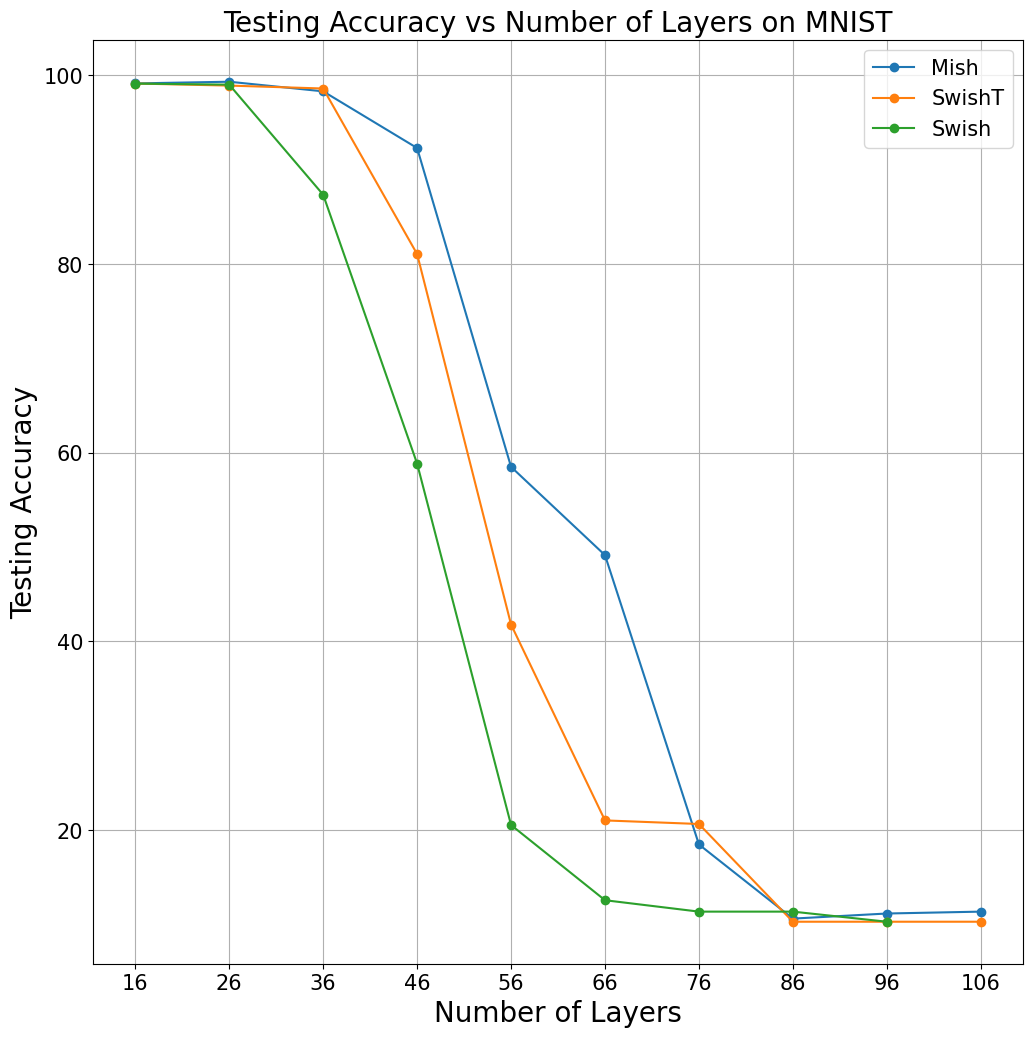

106  layers
cuda:0
0  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3018, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

5  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3017, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

9  training..

Test set: Average loss: 2.3016, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.2

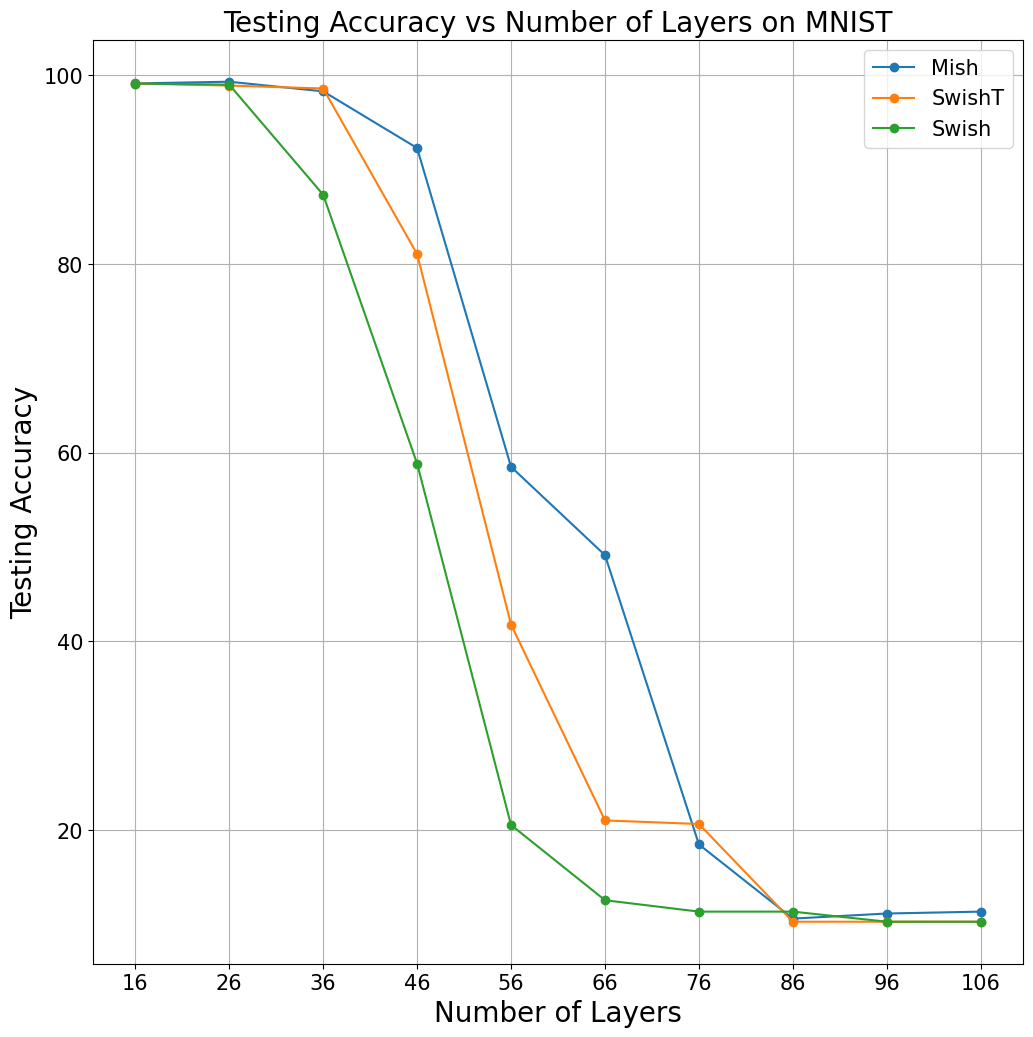

GELU 16  layers
cuda:0
0  training..

Test set: Average loss: 0.0820, Accuracy: 9779/10000 (98%)

1  training..

Test set: Average loss: 0.0511, Accuracy: 9858/10000 (99%)

2  training..

Test set: Average loss: 0.0415, Accuracy: 9893/10000 (99%)

3  training..

Test set: Average loss: 0.0435, Accuracy: 9886/10000 (99%)

4  training..

Test set: Average loss: 0.0372, Accuracy: 9903/10000 (99%)

5  training..

Test set: Average loss: 0.0382, Accuracy: 9883/10000 (99%)

6  training..

Test set: Average loss: 0.0335, Accuracy: 9915/10000 (99%)

7  training..

Test set: Average loss: 0.0325, Accuracy: 9909/10000 (99%)

8  training..

Test set: Average loss: 0.0308, Accuracy: 9921/10000 (99%)

9  training..

Test set: Average loss: 0.0329, Accuracy: 9920/10000 (99%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 

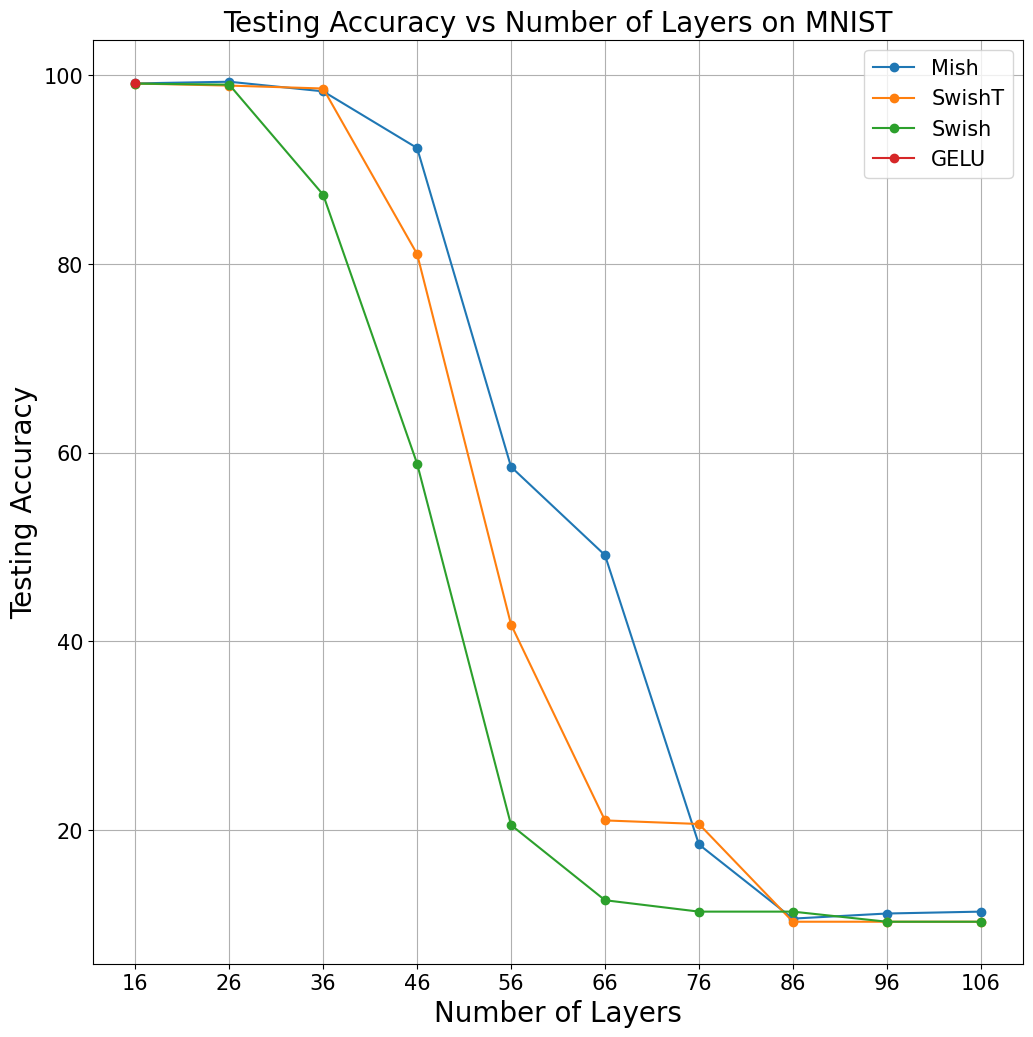

26  layers
cuda:0
0  training..

Test set: Average loss: 0.7863, Accuracy: 6613/10000 (66%)

1  training..

Test set: Average loss: 0.2940, Accuracy: 9419/10000 (94%)

2  training..

Test set: Average loss: 0.1216, Accuracy: 9754/10000 (98%)

3  training..

Test set: Average loss: 0.1152, Accuracy: 9769/10000 (98%)

4  training..

Test set: Average loss: 0.0978, Accuracy: 9817/10000 (98%)

5  training..

Test set: Average loss: 0.0872, Accuracy: 9832/10000 (98%)

6  training..

Test set: Average loss: 0.0698, Accuracy: 9860/10000 (99%)

7  training..

Test set: Average loss: 0.0515, Accuracy: 9895/10000 (99%)

8  training..

Test set: Average loss: 0.0495, Accuracy: 9903/10000 (99%)

9  training..

Test set: Average loss: 0.0538, Accuracy: 9900/10000 (99%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

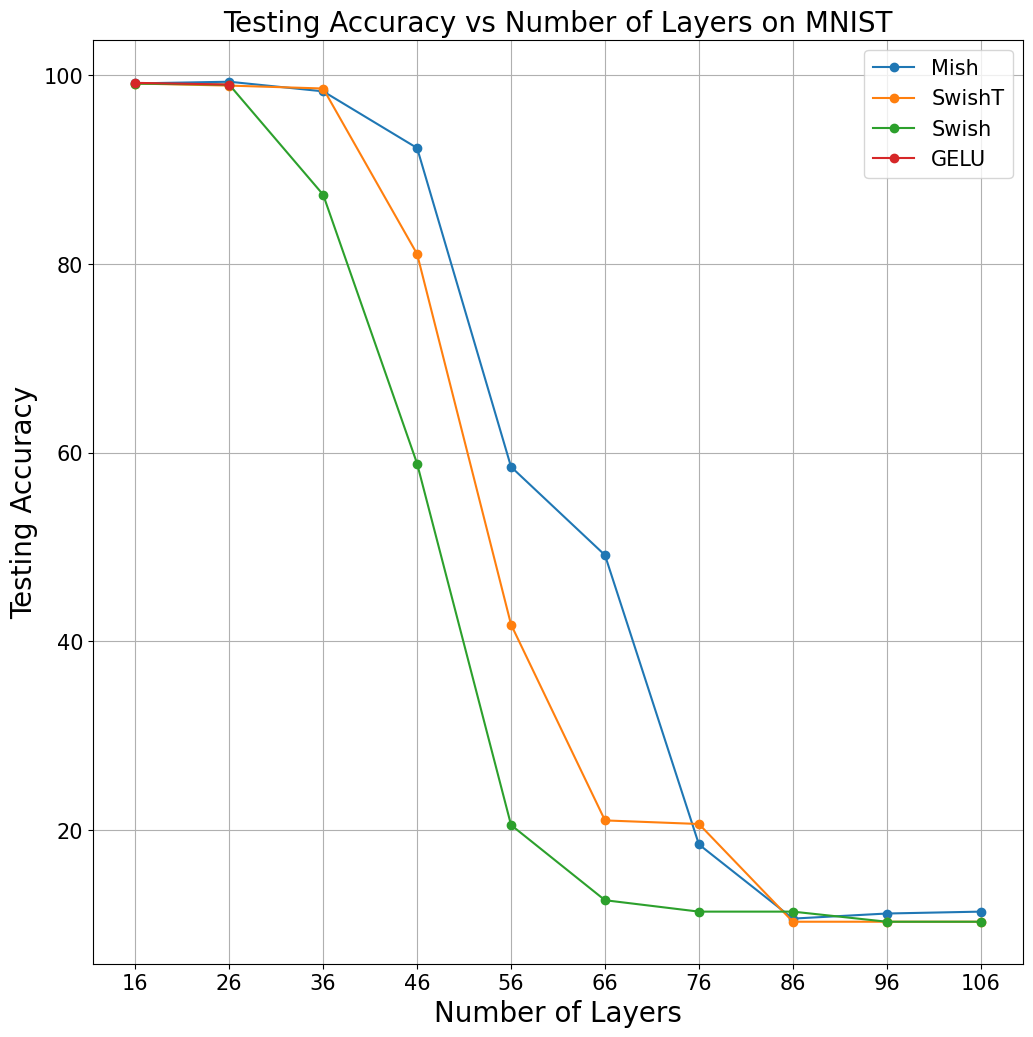

36  layers
cuda:0
0  training..

Test set: Average loss: 2.2694, Accuracy: 1244/10000 (12%)

1  training..

Test set: Average loss: 2.1057, Accuracy: 1542/10000 (15%)

2  training..

Test set: Average loss: 0.9416, Accuracy: 6410/10000 (64%)

3  training..

Test set: Average loss: 0.6875, Accuracy: 6748/10000 (67%)

4  training..

Test set: Average loss: 3.7581, Accuracy: 1039/10000 (10%)

5  training..

Test set: Average loss: 0.5850, Accuracy: 7799/10000 (78%)

6  training..

Test set: Average loss: 0.4703, Accuracy: 8237/10000 (82%)

7  training..

Test set: Average loss: 0.3395, Accuracy: 8687/10000 (87%)

8  training..

Test set: Average loss: 0.3058, Accuracy: 8785/10000 (88%)

9  training..

Test set: Average loss: 0.2534, Accuracy: 8869/10000 (89%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

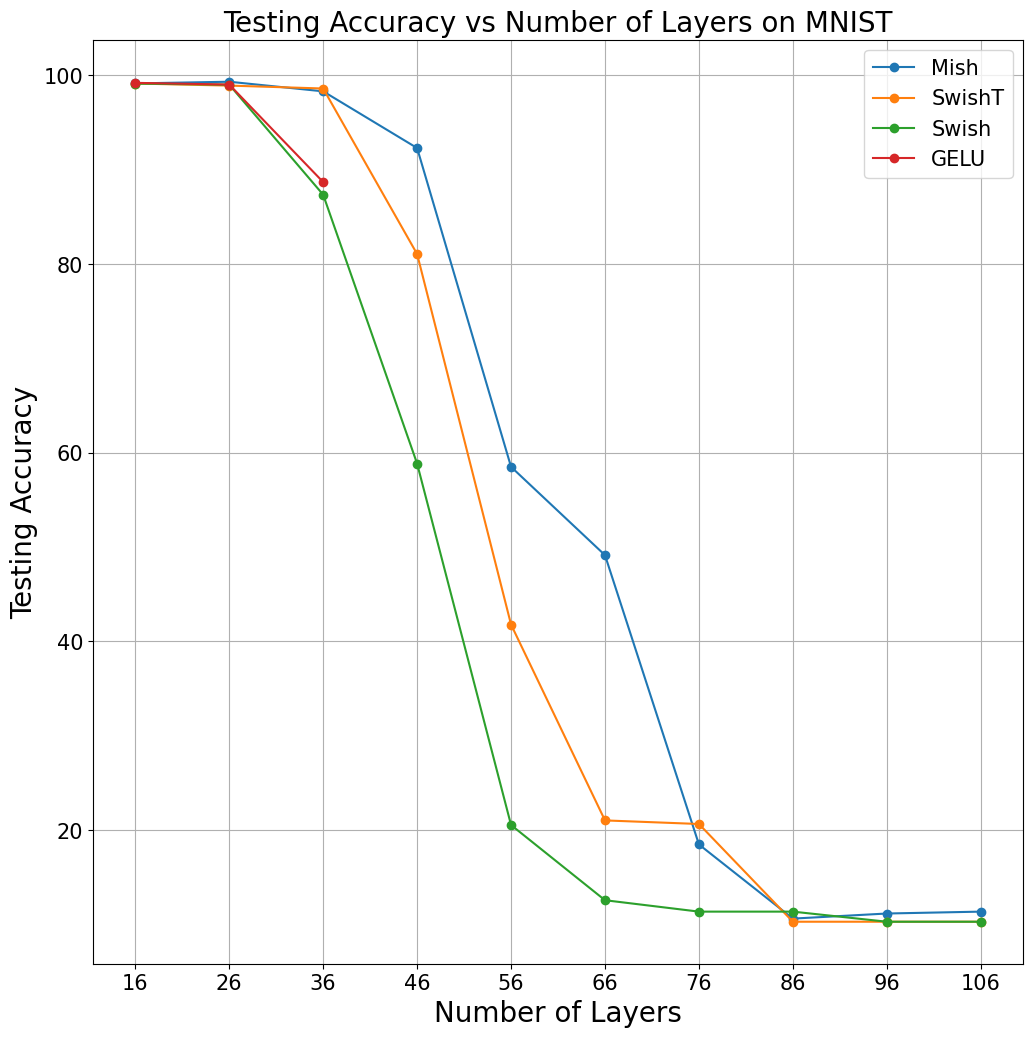

46  layers
cuda:0
0  training..

Test set: Average loss: 2.3235, Accuracy: 1034/10000 (10%)

1  training..

Test set: Average loss: 2.2176, Accuracy: 1389/10000 (14%)

2  training..

Test set: Average loss: 2.1758, Accuracy: 1557/10000 (16%)

3  training..

Test set: Average loss: 2.1068, Accuracy: 1768/10000 (18%)

4  training..

Test set: Average loss: 2.0694, Accuracy: 1881/10000 (19%)

5  training..

Test set: Average loss: 2.0433, Accuracy: 1973/10000 (20%)

6  training..

Test set: Average loss: 2.0308, Accuracy: 2089/10000 (21%)

7  training..

Test set: Average loss: 2.0228, Accuracy: 1988/10000 (20%)

8  training..

Test set: Average loss: 1.4700, Accuracy: 3635/10000 (36%)

9  training..

Test set: Average loss: 1.2436, Accuracy: 4107/10000 (41%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

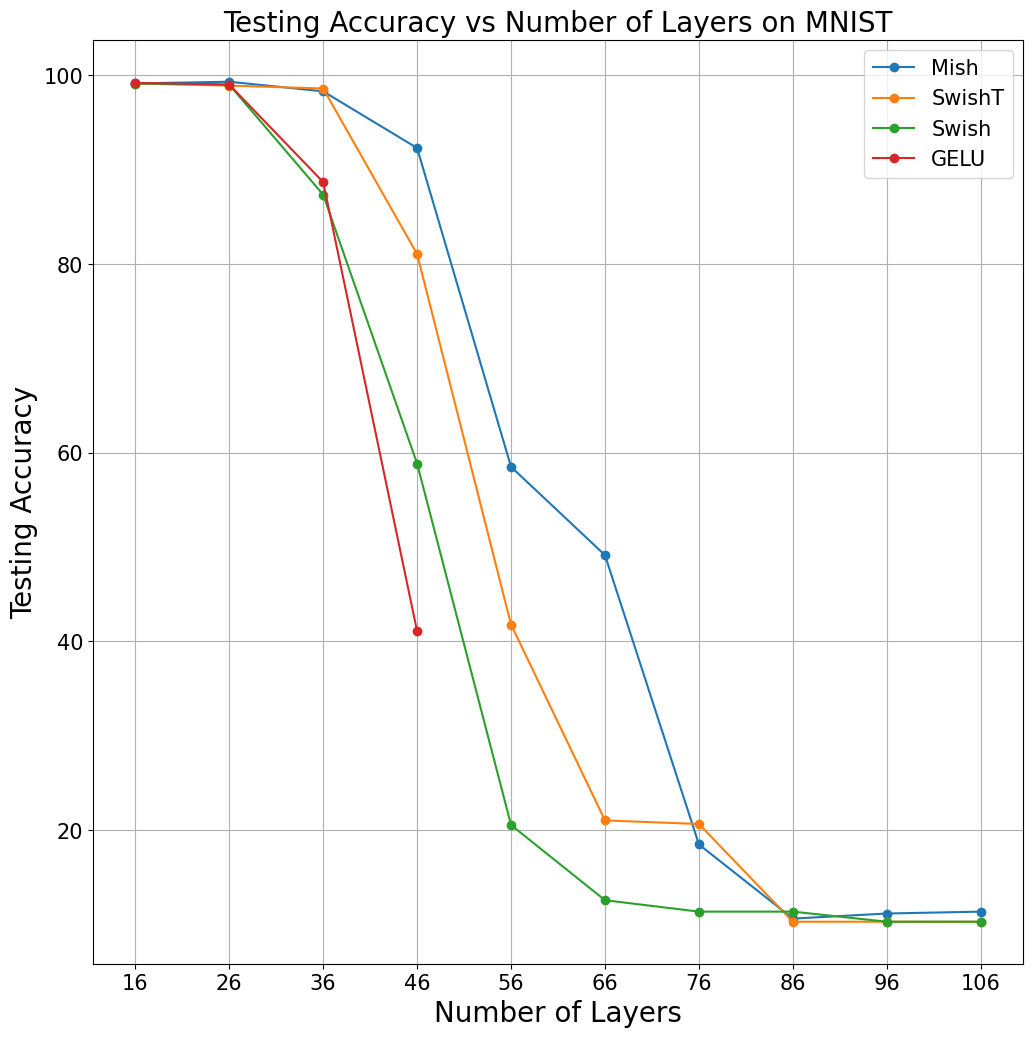

56  layers
cuda:0
0  training..

Test set: Average loss: 2.3080, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3071, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3077, Accuracy: 1135/10000 (11%)

3  training..

Test set: Average loss: 2.3083, Accuracy: 1037/10000 (10%)

4  training..

Test set: Average loss: 2.2794, Accuracy: 1247/10000 (12%)

5  training..

Test set: Average loss: 2.2903, Accuracy: 1141/10000 (11%)

6  training..

Test set: Average loss: 2.2802, Accuracy: 1200/10000 (12%)

7  training..

Test set: Average loss: 2.2777, Accuracy: 1194/10000 (12%)

8  training..

Test set: Average loss: 2.2816, Accuracy: 1148/10000 (11%)

9  training..

Test set: Average loss: 2.2485, Accuracy: 1322/10000 (13%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

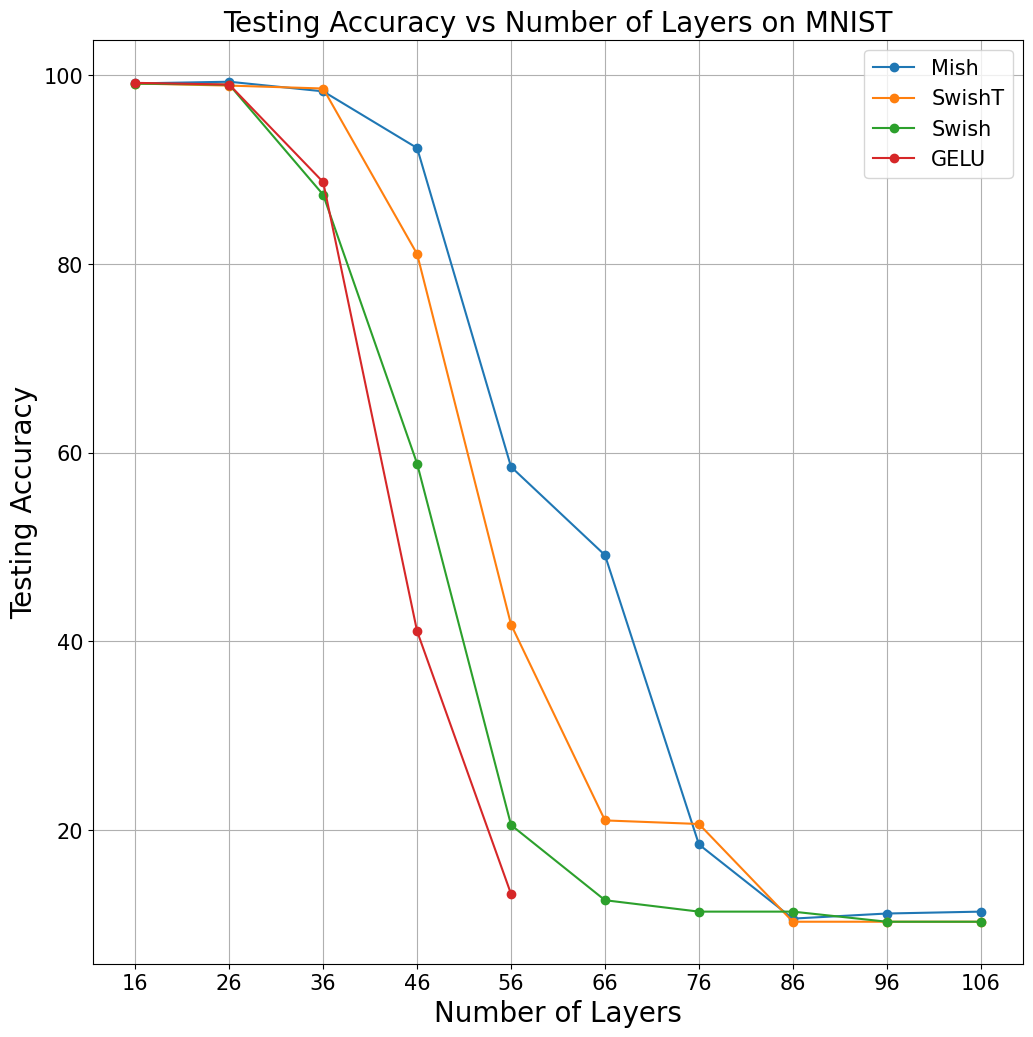

66  layers
cuda:0
0  training..

Test set: Average loss: 2.3042, Accuracy: 1135/10000 (11%)

1  training..

Test set: Average loss: 2.3050, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3064, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3054, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3058, Accuracy: 1030/10000 (10%)

5  training..

Test set: Average loss: 2.3046, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3055, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3042, Accuracy: 1135/10000 (11%)

8  training..

Test set: Average loss: 2.3053, Accuracy: 1031/10000 (10%)

9  training..

Test set: Average loss: 2.3001, Accuracy: 1063/10000 (11%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

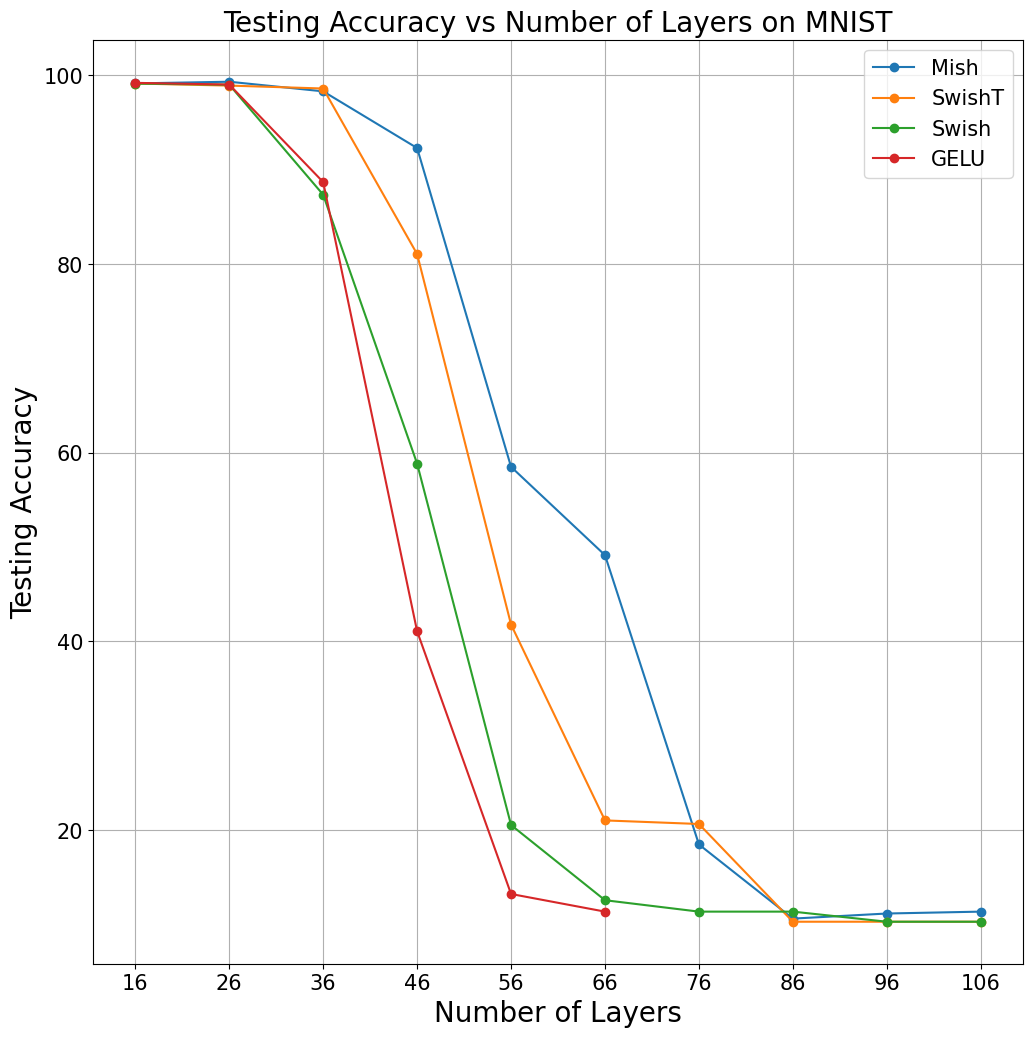

76  layers
cuda:0
0  training..

Test set: Average loss: 2.3017, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3033, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3058, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3045, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3058, Accuracy: 1028/10000 (10%)

5  training..

Test set: Average loss: 2.3057, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3077, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3072, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3069, Accuracy: 1028/10000 (10%)

9  training..

Test set: Average loss: 2.3094, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

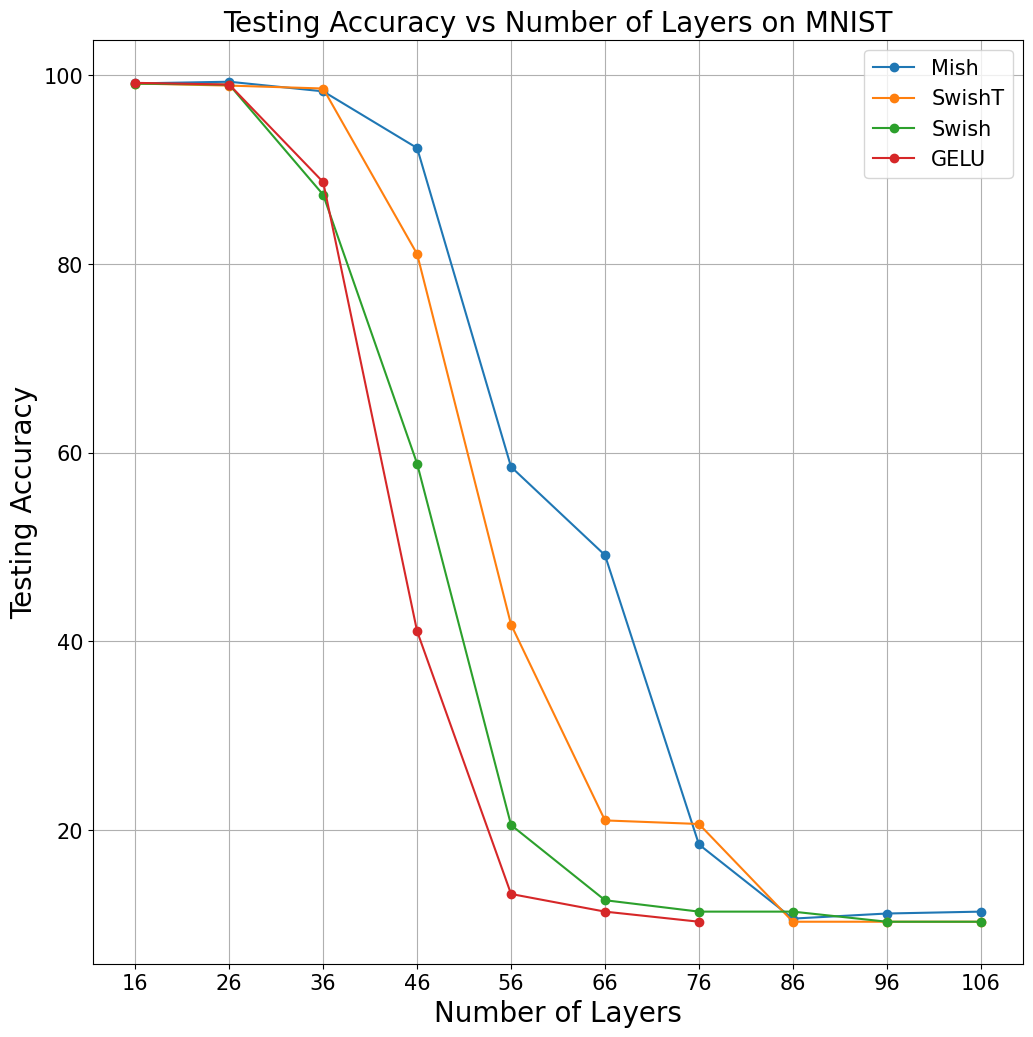

86  layers
cuda:0
0  training..

Test set: Average loss: 2.3049, Accuracy: 1028/10000 (10%)

1  training..

Test set: Average loss: 2.3058, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3051, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3040, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3062, Accuracy: 1028/10000 (10%)

5  training..

Test set: Average loss: 2.3056, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3052, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3049, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3053, Accuracy: 1028/10000 (10%)

9  training..

Test set: Average loss: 2.3051, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

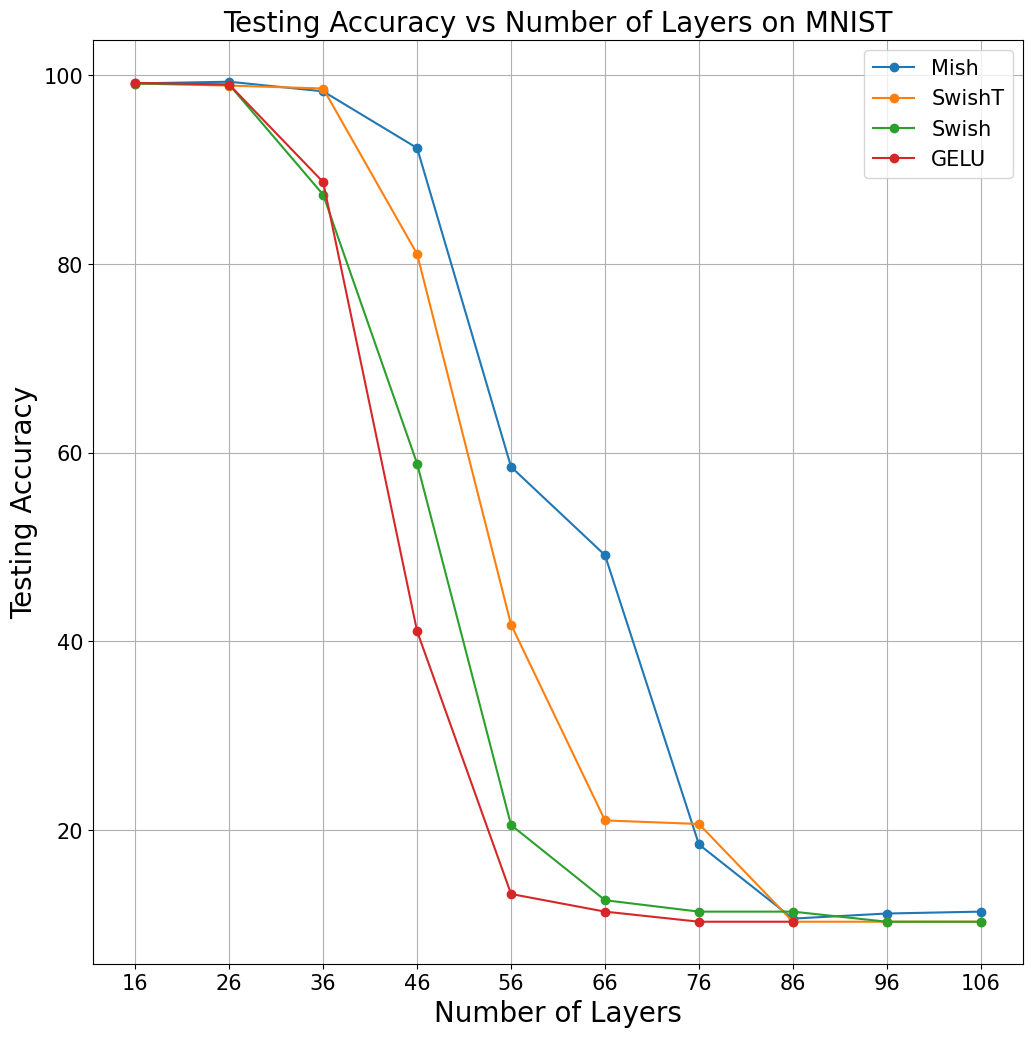

96  layers
cuda:0
0  training..

Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11%)

1  training..

Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11%)

2  training..

Test set: Average loss: 2.3014, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3012, Accuracy: 1135/10000 (11%)

4  training..

Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11%)

5  training..

Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11%)

6  training..

Test set: Average loss: 2.3014, Accuracy: 1135/10000 (11%)

7  training..

Test set: Average loss: 2.3015, Accuracy: 1135/10000 (11%)

8  training..

Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11%)

9  training..

Test set: Average loss: 2.3014, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.28

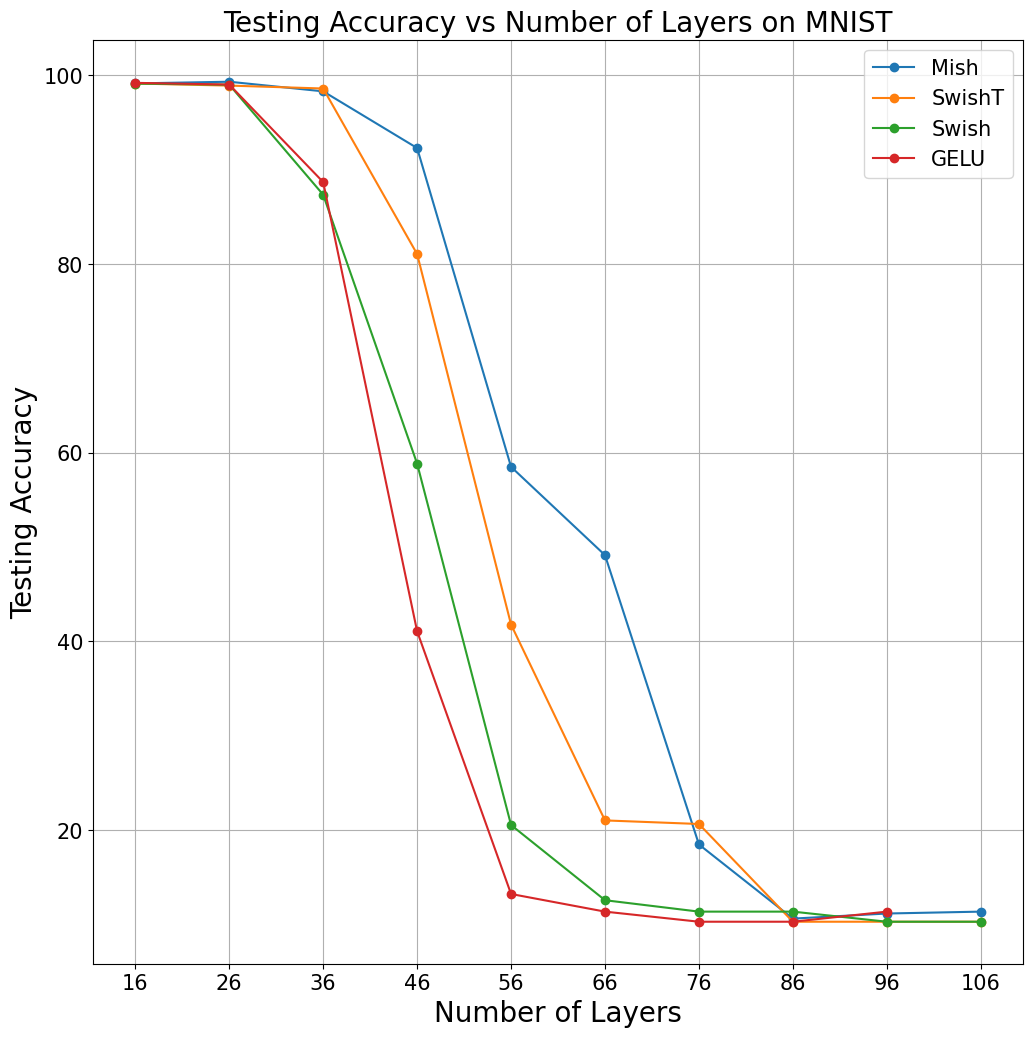

106  layers
cuda:0
0  training..

Test set: Average loss: 2.3019, Accuracy: 1010/10000 (10%)

1  training..

Test set: Average loss: 2.3024, Accuracy: 1028/10000 (10%)

2  training..

Test set: Average loss: 2.3025, Accuracy: 1028/10000 (10%)

3  training..

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)

5  training..

Test set: Average loss: 2.3027, Accuracy: 1028/10000 (10%)

6  training..

Test set: Average loss: 2.3024, Accuracy: 1028/10000 (10%)

7  training..

Test set: Average loss: 2.3021, Accuracy: 1028/10000 (10%)

8  training..

Test set: Average loss: 2.3026, Accuracy: 1028/10000 (10%)

9  training..

Test set: Average loss: 2.3023, Accuracy: 1028/10000 (10%)

{'Mish': [99.15, 99.33, 98.31, 92.3, 58.5, 49.14, 18.47, 10.61, 11.15, 11.35], 'SwishT': [99.14, 98.92, 98.61, 81.06, 41.78, 21.02, 20.64, 10.28, 10.28, 10.28], 'Swish': [99.13, 99.02, 87.35, 58.84, 20.53, 12.56, 11.35, 11.35, 10.2

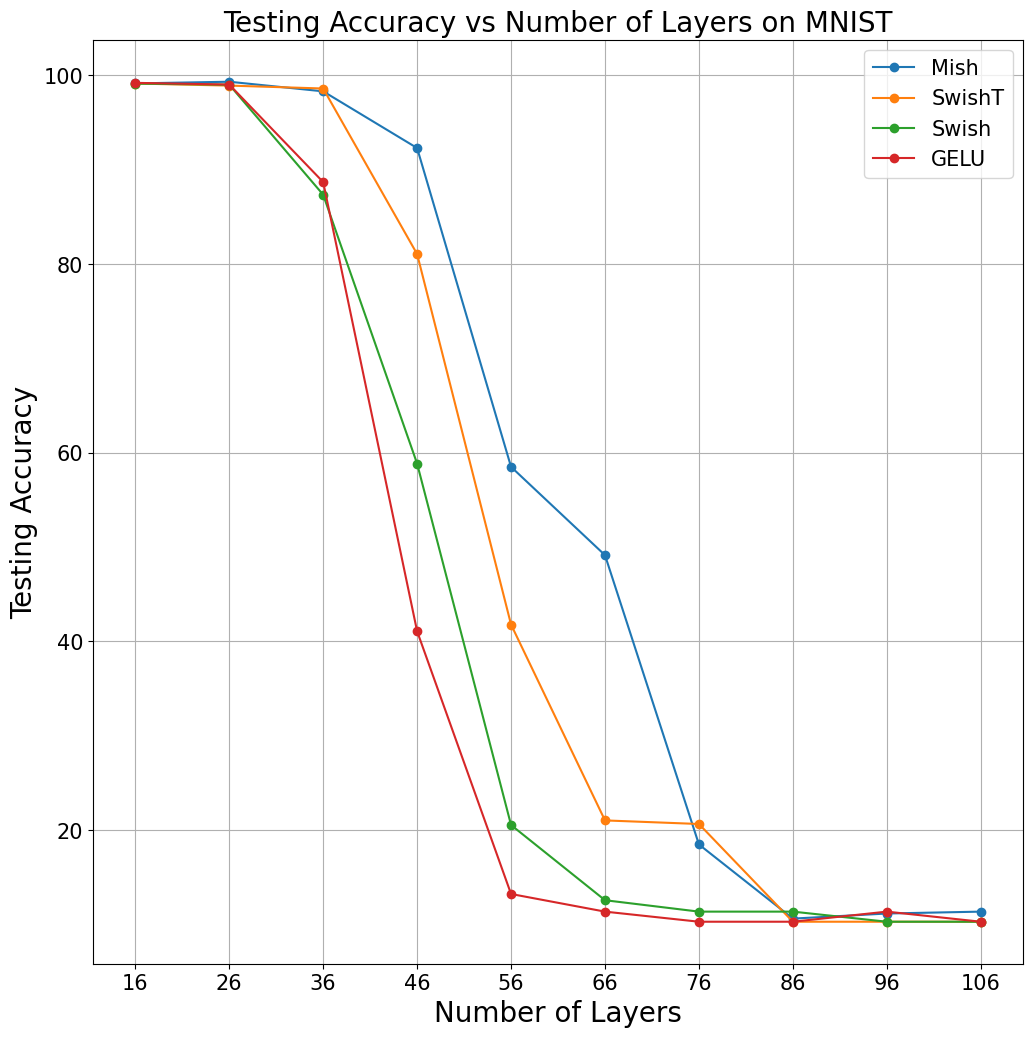

In [110]:
results = {}
activations = {
  'Mish':nn.Mish(),
  'SwishT':SwishT(),
  'Swish':Swish(),
  'GELU':nn.GELU(),
}
range_ = []
for name,act in activations.items():
  print(name,end=' ')
  results[name] = []
  
  # for n in range(16,end+end%slides,step):
  for n in range(16,107,10):
    print(n,' layers')
    test_acc = model_relu(num_layers=n,activation=act,epochs=conf.epochs)
    results[name].append(test_acc)
    print(results)
    plot_result(results)
    
    

In [ ]:
results = {}
activations = {
  'Mish':nn.Mish(),
  'SwishT':SwishT(),
  'Swish':Swish(),
  'GELU':nn.GELU(),
}
range_ = []
for name,act in activations.items():
  print(name,end=' ')
  results[name] = []
  
  # for n in range(16,end+end%slides,step):
  for n in range(16,107,10):
    print(n,' layers')
    test_acc = model_relu(num_layers=n,activation=act,epochs=conf.epochs)
    results[name].append(test_acc)
    print(results)
    plot_result(results)
    
    

# CIFAR100

Mish 16  layers
cuda:0
0  training..

Test set: Average loss: 4.0599, Accuracy: 650/10000 (6%)

1  training..

Test set: Average loss: 3.8937, Accuracy: 857/10000 (9%)

2  training..

Test set: Average loss: 3.8288, Accuracy: 1049/10000 (10%)

3  training..

Test set: Average loss: 3.9876, Accuracy: 1028/10000 (10%)

4  training..

Test set: Average loss: 3.6980, Accuracy: 1307/10000 (13%)

5  training..

Test set: Average loss: 3.9131, Accuracy: 1306/10000 (13%)

6  training..

Test set: Average loss: 3.2679, Accuracy: 1821/10000 (18%)

7  training..

Test set: Average loss: 3.2266, Accuracy: 2071/10000 (21%)

8  training..

Test set: Average loss: 3.4842, Accuracy: 1796/10000 (18%)

9  training..

Test set: Average loss: 3.3380, Accuracy: 2033/10000 (20%)

{'Mish': [20.71]}


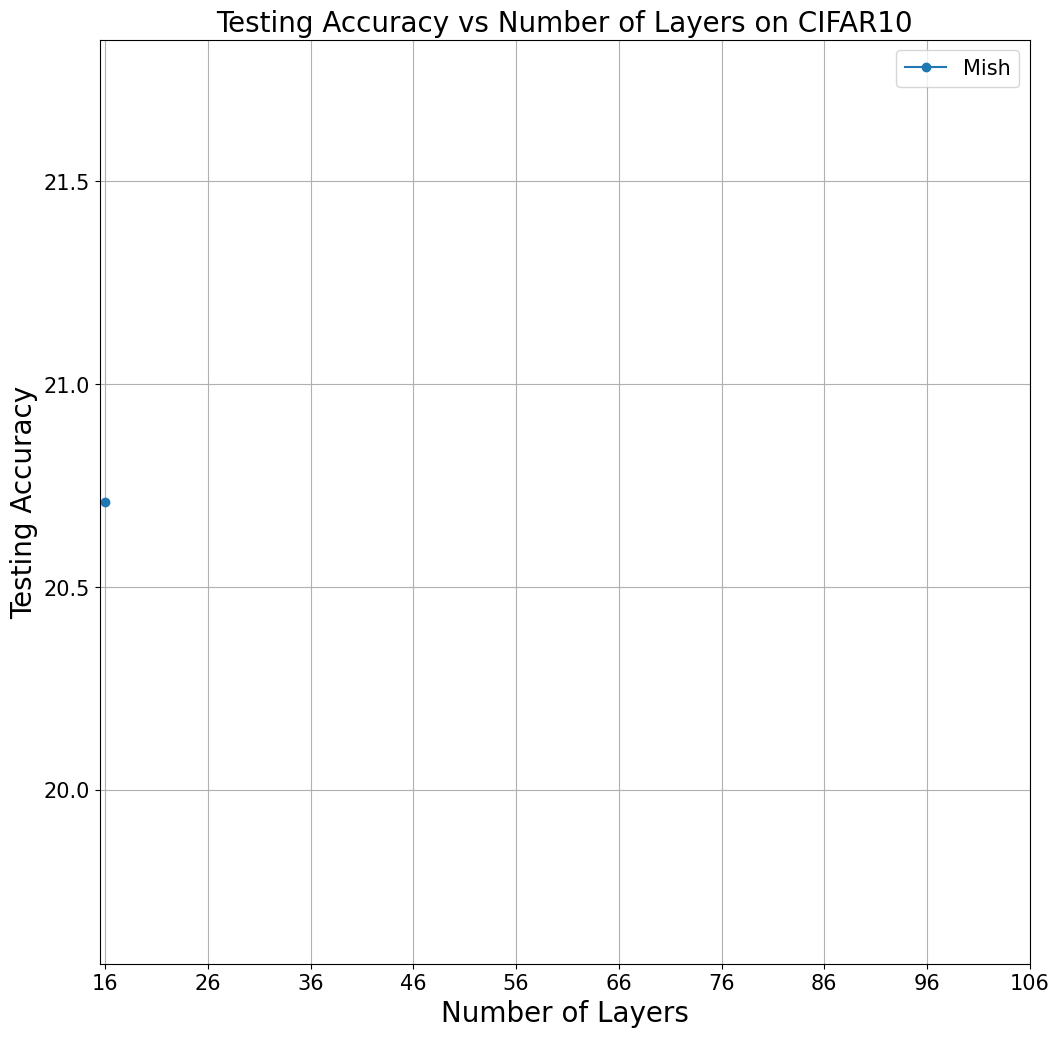

26  layers
cuda:0
0  training..

Test set: Average loss: 4.6341, Accuracy: 102/10000 (1%)

1  training..

Test set: Average loss: 4.7804, Accuracy: 179/10000 (2%)

2  training..

Test set: Average loss: 4.3030, Accuracy: 350/10000 (4%)

3  training..

Test set: Average loss: 4.2869, Accuracy: 345/10000 (3%)

4  training..

Test set: Average loss: 4.0479, Accuracy: 564/10000 (6%)

5  training..

Test set: Average loss: 3.9950, Accuracy: 643/10000 (6%)

6  training..

Test set: Average loss: 3.9319, Accuracy: 713/10000 (7%)

7  training..

Test set: Average loss: 3.8948, Accuracy: 832/10000 (8%)

8  training..

Test set: Average loss: 3.8798, Accuracy: 817/10000 (8%)

9  training..

Test set: Average loss: 3.8035, Accuracy: 890/10000 (9%)

{'Mish': [20.71, 8.9]}


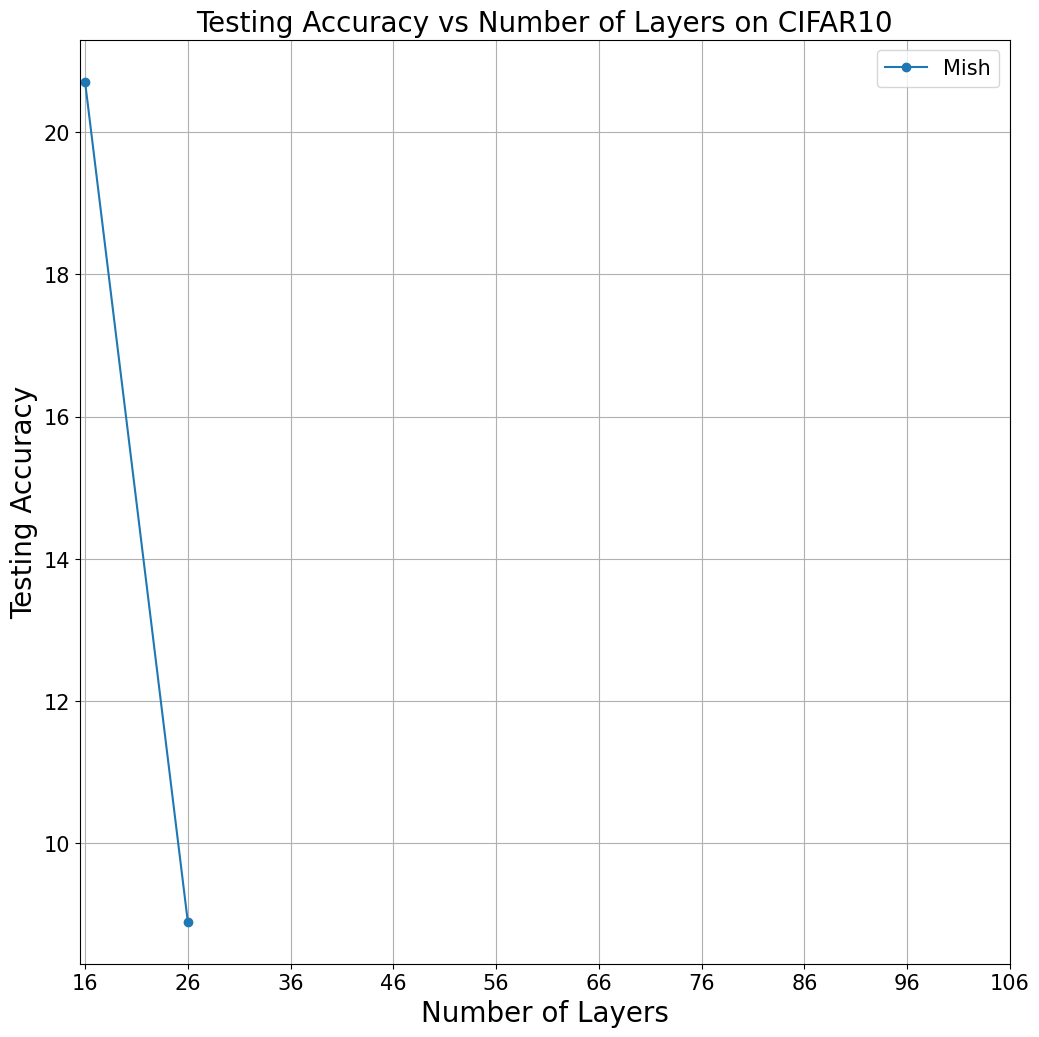

36  layers
cuda:0
0  training..

Test set: Average loss: 4.6224, Accuracy: 100/10000 (1%)

1  training..

Test set: Average loss: 4.5509, Accuracy: 145/10000 (1%)

2  training..

Test set: Average loss: 4.4122, Accuracy: 246/10000 (2%)

3  training..

Test set: Average loss: 4.3533, Accuracy: 279/10000 (3%)

4  training..

Test set: Average loss: 4.3937, Accuracy: 262/10000 (3%)

5  training..

Test set: Average loss: 4.2909, Accuracy: 290/10000 (3%)

6  training..

Test set: Average loss: 4.2553, Accuracy: 361/10000 (4%)

7  training..

Test set: Average loss: 4.1712, Accuracy: 397/10000 (4%)

8  training..

Test set: Average loss: 4.3316, Accuracy: 338/10000 (3%)

9  training..

Test set: Average loss: 4.1563, Accuracy: 380/10000 (4%)

{'Mish': [20.71, 8.9, 3.97]}


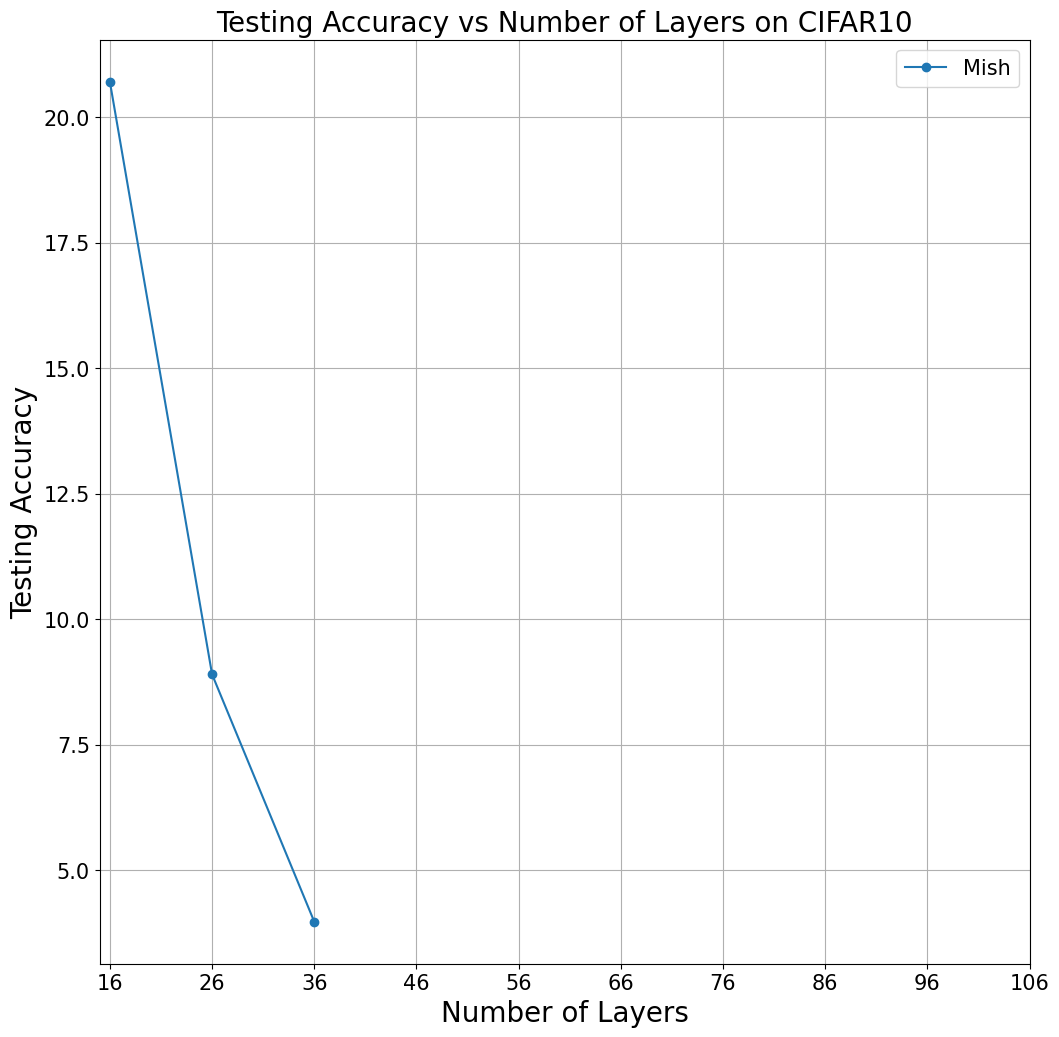

46  layers
cuda:0
0  training..

Test set: Average loss: 4.6112, Accuracy: 100/10000 (1%)

1  training..

Test set: Average loss: 4.5994, Accuracy: 116/10000 (1%)

2  training..

Test set: Average loss: 4.5587, Accuracy: 174/10000 (2%)

3  training..

Test set: Average loss: 4.5533, Accuracy: 174/10000 (2%)

4  training..

Test set: Average loss: 4.5485, Accuracy: 143/10000 (1%)

5  training..

Test set: Average loss: 4.4962, Accuracy: 192/10000 (2%)

6  training..

Test set: Average loss: 4.3709, Accuracy: 232/10000 (2%)

7  training..

Test set: Average loss: 4.3252, Accuracy: 241/10000 (2%)

8  training..

Test set: Average loss: 4.2713, Accuracy: 299/10000 (3%)

9  training..

Test set: Average loss: 4.2817, Accuracy: 277/10000 (3%)

{'Mish': [20.71, 8.9, 3.97, 2.99]}


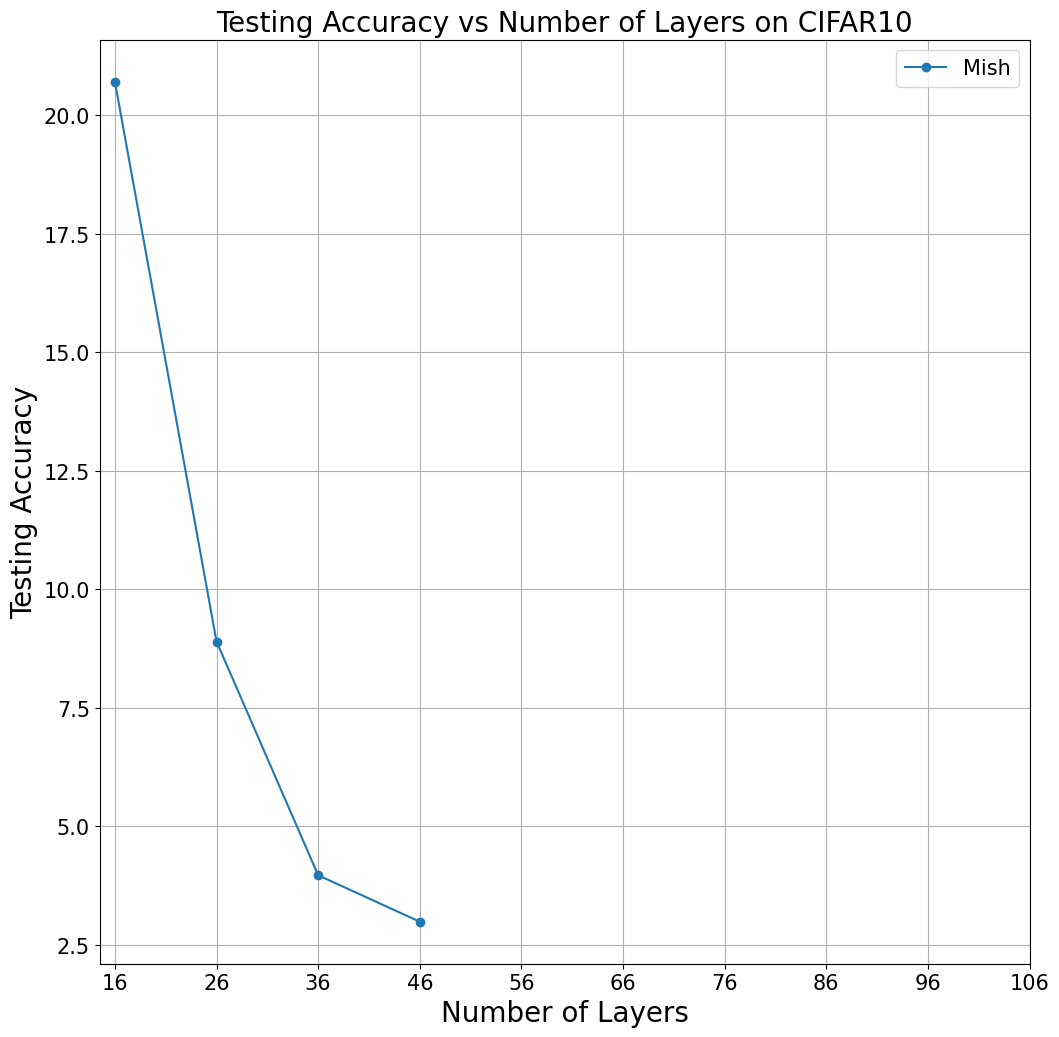

56  layers
cuda:0
0  training..

Test set: Average loss: 4.6073, Accuracy: 100/10000 (1%)

1  training..

Test set: Average loss: 4.5954, Accuracy: 119/10000 (1%)

2  training..

Test set: Average loss: 4.5481, Accuracy: 161/10000 (2%)

3  training..

Test set: Average loss: 4.5079, Accuracy: 137/10000 (1%)

4  training..

Test set: Average loss: 4.3894, Accuracy: 274/10000 (3%)

5  training..

Test set: Average loss: 4.3590, Accuracy: 277/10000 (3%)

6  training..

Test set: Average loss: 4.3413, Accuracy: 286/10000 (3%)

7  training..

Test set: Average loss: 4.3239, Accuracy: 267/10000 (3%)

8  training..

Test set: Average loss: 4.2896, Accuracy: 300/10000 (3%)

9  training..

Test set: Average loss: 4.2652, Accuracy: 332/10000 (3%)

{'Mish': [20.71, 8.9, 3.97, 2.99, 3.32]}


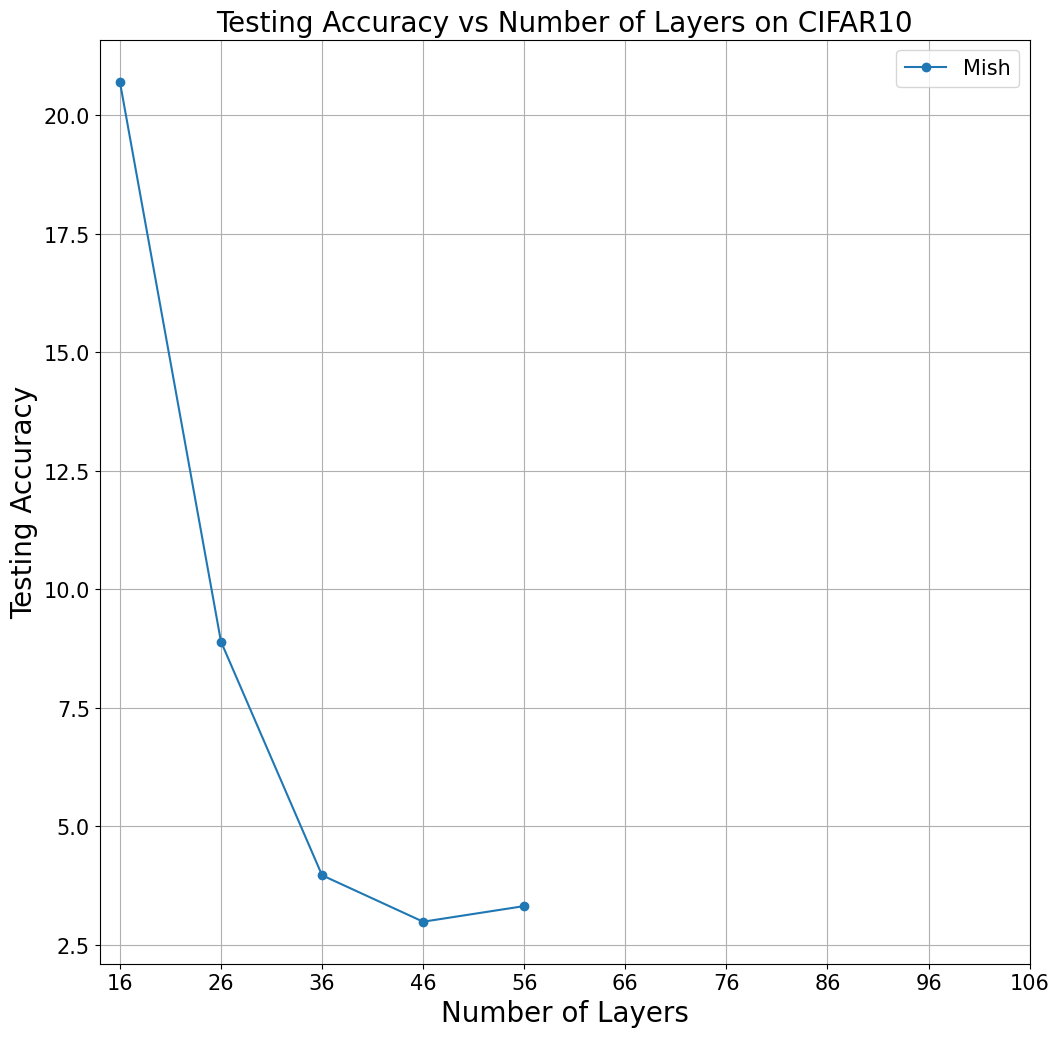

66  layers
cuda:0
0  training..

Test set: Average loss: 4.6057, Accuracy: 100/10000 (1%)

1  training..

Test set: Average loss: 4.6058, Accuracy: 100/10000 (1%)

2  training..

Test set: Average loss: 4.6058, Accuracy: 100/10000 (1%)

3  training..

Test set: Average loss: 4.6059, Accuracy: 100/10000 (1%)

4  training..

Test set: Average loss: 4.6059, Accuracy: 100/10000 (1%)

5  training..

Test set: Average loss: 4.6058, Accuracy: 100/10000 (1%)

6  training..

Test set: Average loss: 4.6060, Accuracy: 100/10000 (1%)

7  training..

Test set: Average loss: 4.6058, Accuracy: 100/10000 (1%)

8  training..

Test set: Average loss: 4.6059, Accuracy: 100/10000 (1%)

9  training..

Test set: Average loss: 4.6058, Accuracy: 100/10000 (1%)

{'Mish': [20.71, 8.9, 3.97, 2.99, 3.32, 1.0]}


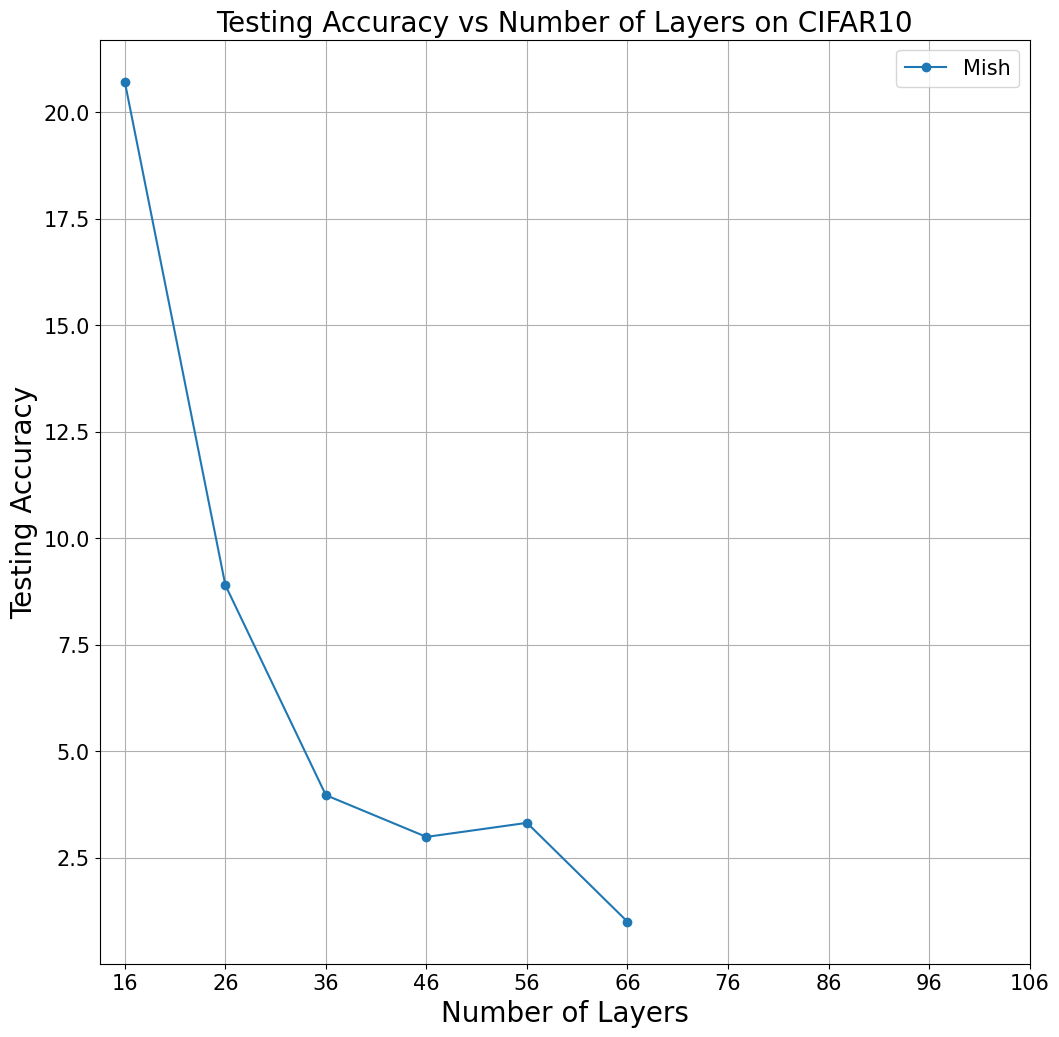

76  layers
cuda:0
0  training..

Test set: Average loss: 4.6060, Accuracy: 100/10000 (1%)

1  training..

Test set: Average loss: 4.6057, Accuracy: 100/10000 (1%)

2  training..

Test set: Average loss: 4.6057, Accuracy: 100/10000 (1%)

3  training..

Test set: Average loss: 4.6059, Accuracy: 100/10000 (1%)

4  training..

Test set: Average loss: 4.6062, Accuracy: 100/10000 (1%)

5  training..


KeyboardInterrupt: 

In [123]:
results = {}
activations = {
  'Mish':nn.Mish(),
  'SwishT':SwishT(),
  'Swish':Swish(),
  'GELU':nn.GELU(),
}
range_ = []
for name,act in activations.items():
  print(name,end=' ')
  results[name] = []
  
  # for n in range(16,end+end%slides,step):
  for n in range(16,77,10):
    print(n,' layers')
    test_acc = model_relu(num_layers=n,activation=act,epochs=conf.epochs)
    results[name].append(test_acc)
    print(results)
    plot_result(results)
    
    